---
### **Objetivo**

**Objetivo geral**: realizar uma triagem AML baseada em dados para identificar padrões de risco e priorizar casos para investigação.

**Objetivo especifico 1**: selecionar e justificar 30 transações suspeitas, indicando as tipologias observadas e produzindo 1 SAR completo para o caso mais relevante.

**Objetivo específico 2**: implementar um sistema de alertas, documentando lógica/limiares, exemplo na base e justificativa de risco

**Objetivo específico 3**: desenvolver e implementar um modelo de Machine Learning para priorização de risco transacional, utilizando aprendizado não supervisionado de forma a complementar o sistema de alertas determinísticos.

**Objetivo específico 4**: comparar os resultados do sistema de alertas determinísticos e do modelo de Machine Learning, analisando sobreposição, diferenças de perfil e complementaridade na priorização de transações

---

### **Carregamento dos dados e importação de bibliotecas**

In [1]:
# Bibliotecas
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")

# Conexão com banco de dados
conn = duckdb.connect()

# Configurações Tabela
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# Carregamento dos arquivos como tabelas temporárias
conn.execute("CREATE OR REPLACE TEMPORARY TABLE transactions AS SELECT * FROM 'data/processed/transactions.parquet'")
conn.execute("CREATE OR REPLACE TEMPORARY TABLE kyc_profiles AS SELECT * FROM 'data/processed/kyc_profiles.parquet'")
conn.execute("CREATE OR REPLACE TEMPORARY TABLE merchants AS SELECT * FROM 'data/processed/merchants.parquet'")
conn.execute("CREATE OR REPLACE TEMPORARY TABLE geo_behavior AS SELECT * FROM 'data/processed/geo_behavior.parquet'")

In [3]:
def missing_values(dataframe):
    missing = dataframe.isnull().sum()
    missing = missing[missing > 0]
    missing_percent = (missing / len(dataframe)) * 100
    return pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})

def shape_info(dataframe, name="DataFrame"):
    n_cols = dataframe.shape[1]
    n_rows = dataframe.shape[0]
    print(f"{name} - DataFrame has {n_rows} rows and {n_cols} columns.")

### **Organização do projeto**

- **1. Enriquecimento dos dados**
- **2. Análise de anomalias/tipologias de AML**
- **3. Definição de alertas**
- **4. Casos suspeitos + SAR**
- **5. Modelo de machine learnig**
- **6. Comparação da abordagem deterministica x machine learnig**

### **1. Enriquecimento dos dados**

Foi criada a tabela transactions_enriched para consolidar dados de emissores (Senders) e recebedores (Receivers) em uma única linha, permitindo o cruzamento imediato de riscos (ex: PEP transacionando em MCC de alto risco).

#### **1.1. Criação da tabela base intregrada**

In [4]:
# Enriquecimento dos dados: criando tabela transactions_enriched com joins
query_base = """
CREATE OR REPLACE TABLE transactions_enriched AS
SELECT 
    --  DADOS ORIGINAIS DA TRANSAÇÃO 
    t.transaction_id,
    t.timestamp,
    t.transaction_type,
    t.sender_id,
    t.sender_entity_type,
    t.receiver_id,
    t.receiver_entity_type,
    t.amount_brl,
    t.amount_orig,
    t.currency,
    t.fx_to_brl,
    t.status,
    t.channel,
    t.capture_method,
    t.payment_method,
    t.installments,
    t.issuing_or_acquiring,
    t.pix,
    t.pix_flow,
    t.card_brand,
    t.card_present,
    t.auth_3ds,
    t.eci,
    t.mcc,
    t.geo_country,
    t.geolocation_lat,
    t.geolocation_lon,
    t.ip_country,
    t.ip_anomaly,
    t.ip_proxy_vpn_tor,
    t.device_fingerprint,
    t.ip_address,
    t.device_rooted,
    t.sender_country,
    t.receiver_country,
    t.country_risk_geo,
    t.country_risk_ip,
    t.country_risk_sender,
    t.country_risk_receiver,
    t.cross_border,
    t.sanctions_screening_hit,
    
    --  DADOS DO SENDER (Pessoa ou Empresa) 
    CASE 
        WHEN t.sender_entity_type = 'customer' THEN sk.full_name
        WHEN t.sender_entity_type = 'merchant' THEN sm.merchant_name
        ELSE NULL 
    END AS sender_name,
    
    CASE 
        WHEN t.sender_entity_type = 'customer' THEN sk.cpf_cnpj
        WHEN t.sender_entity_type = 'merchant' THEN sm.cnpj
        ELSE NULL 
    END AS sender_document,
    
    -- Dados de KYC: Agora apenas se o sender for 'customer'
    sk.annual_income_brl AS sender_income,
    sk.declared_occupation AS sender_occupation,
    sk.risk_rating AS sender_risk_rating,
    sk.registration_date AS sender_registration_date,
    sk.pep AS sender_pep,
    sk.kyc_tier AS sender_kyc_tier,
    sk.kyc_risk_score AS sender_kyc_score,
    sk.sanctions_list_hit AS sender_sanctions_hit,
    sk.date_of_birth AS sender_dob,
    
    -- Dados de Merchant: Agora apenas se o sender for 'merchant'
    sm.merchant_id AS sender_merchant_id,
    sm.owner_customer_id AS sender_merchant_owner_id,
    sm.merchant_high_risk_flag AS sender_merchant_high_risk,
    sm.merchant_chargeback_ratio_90d AS sender_chargeback_ratio,
    sm.mcc_risk AS sender_mcc_risk,
    
    --  DADOS DO RECEIVER (Pessoa ou Empresa) 
    CASE 
        WHEN t.receiver_entity_type = 'customer' THEN rk.full_name
        WHEN t.receiver_entity_type = 'merchant' THEN rm.merchant_name
        ELSE NULL 
    END AS receiver_name,
    
    CASE 
        WHEN t.receiver_entity_type = 'customer' THEN rk.cpf_cnpj
        WHEN t.receiver_entity_type = 'merchant' THEN rm.cnpj
        ELSE NULL 
    END AS receiver_document,
    
    -- Dados de KYC: Apenas se o receiver for 'customer'
    rk.annual_income_brl AS receiver_income,
    rk.risk_rating AS receiver_risk_rating,
    rk.pep AS receiver_pep,
    rk.kyc_risk_score AS receiver_kyc_score,
    rk.sanctions_list_hit AS receiver_sanctions_hit,
    
    -- Dados de Merchant: Apenas se o receiver for 'merchant'
    rm.merchant_id AS receiver_merchant_id,
    rm.owner_customer_id AS receiver_merchant_owner_id,
    rm.merchant_high_risk_flag AS receiver_merchant_high_risk,
    rm.merchant_chargeback_ratio_90d AS receiver_chargeback_ratio,
    rm.mcc_risk AS receiver_mcc_risk,
    
    --  DADOS COMPORTAMENTAIS DO SENDER 
    gb.tx_count AS sender_tx_count,
    gb.counterparties AS sender_counterparties,
    gb.avg_amount AS sender_avg_amount,
    gb.tx_window_days AS sender_tx_window_days,
    gb.tx_per_day AS sender_tx_per_day

FROM transactions t

-- JOINS PARA SENDER
LEFT JOIN kyc_profiles sk 
    ON t.sender_id = sk.customer_id 
    AND t.sender_entity_type = 'customer'

LEFT JOIN merchants sm 
    ON t.sender_id = sm.merchant_id 
    AND t.sender_entity_type = 'merchant'

-- JOINS PARA RECEIVER
LEFT JOIN kyc_profiles rk 
    ON t.receiver_id = rk.customer_id 
    AND t.receiver_entity_type = 'customer'

LEFT JOIN merchants rm 
    ON t.receiver_id = rm.merchant_id 
    AND t.receiver_entity_type = 'merchant'

-- JOIN COM GEO BEHAVIOR (Mantido para ambos, pois a tabela tem IDs C e M)
LEFT JOIN geo_behavior gb 
    ON t.sender_id = gb.sender_id;
"""

conn.execute(query_base)

# Transforma a tabela enriquecida em um dataframe para análises exploratórias
df_transactions_enriched = conn.execute("SELECT * FROM transactions_enriched").df()

# Verificando os primeiros registros do dataframe enriquecido
shape_info(df_transactions_enriched, "Transactions Enriched")
display(df_transactions_enriched.head(3))
display(df_transactions_enriched.tail(3))


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Transactions Enriched - DataFrame has 52000 rows and 74 columns.


,transaction_id,timestamp,transaction_type,sender_id,sender_entity_type,receiver_id,receiver_entity_type,amount_brl,amount_orig,currency,fx_to_brl,status,channel,capture_method,payment_method,installments,issuing_or_acquiring,pix,pix_flow,card_brand,card_present,auth_3ds,eci,mcc,geo_country,geolocation_lat,geolocation_lon,ip_country,ip_anomaly,ip_proxy_vpn_tor,device_fingerprint,ip_address,device_rooted,sender_country,receiver_country,country_risk_geo,country_risk_ip,country_risk_sender,country_risk_receiver,cross_border,sanctions_screening_hit,sender_name,sender_document,sender_income,sender_occupation,sender_risk_rating,sender_registration_date,sender_pep,sender_kyc_tier,sender_kyc_score,sender_sanctions_hit,sender_dob,sender_merchant_id,sender_merchant_owner_id,sender_merchant_high_risk,sender_chargeback_ratio,sender_mcc_risk,receiver_name,receiver_document,receiver_income,receiver_risk_rating,receiver_pep,receiver_kyc_score,receiver_sanctions_hit,receiver_merchant_id,receiver_merchant_owner_id,receiver_merchant_high_risk,receiver_chargeback_ratio,receiver_mcc_risk,sender_tx_count,sender_counterparties,sender_avg_amount,sender_tx_window_days,sender_tx_per_day
0,TB9YE5TCX4DFA,2025-09-04 13:14:11,Card,C101373,customer,M200001,merchant,12521.40,12521.40,BRL,1.0,Confirmed,Web,Magstripe,debit,1,acquiring,False,None,Mastercard,True,<NA>,NaN,7995,BR,-29.032076,-38.360873,BR,False,None,s46zr5vn4y4yuevo,235.127.179.215,False,BR,BR,Low,Low,Low,Low,False,False,Customer 1374,98399058768,34248,Lawyer,Low,2024-11-21,False,L2,6,False,1980-04-26,None,None,<NA>,NaN,None,Merchant 2,96297252396610,<NA>,None,<NA>,<NA>,<NA>,M200001,None,False,0.052,High,22,21,3268.37,89,0.247
1,TC5IQX2AEGP8T,2025-07-30 16:21:21,PIX,C101829,customer,M200002,merchant,1011.23,1011.23,BRL,1.0,Confirmed,App,Pix Key,None,1,None,True,cash_out,None,<NA>,<NA>,NaN,5411,BR,-24.800033,-45.358862,BR,False,None,mf1qmz2e4oeb84in,143.248.154.172,False,BR,BR,Low,Low,Low,Low,False,False,Customer 1830,89712231899,15554,Driver,Low,2025-09-23,False,L1,93,False,1974-12-28,None,None,<NA>,NaN,None,Merchant 3,67551536706595,<NA>,None,<NA>,<NA>,<NA>,M200002,C100993,False,0.060,Normal,20,20,3395.56,91,0.220
2,T03AXHTMB1PQC,2025-07-12 21:25:42,PIX,C101926,customer,M200002,merchant,4855.88,4855.88,BRL,1.0,Confirmed,API,QR Static,None,1,None,True,cash_out,None,<NA>,<NA>,NaN,5411,BR,-10.934797,-40.540270,BR,False,None,xk4jctpff4scke8o,157.237.204.168,False,BR,BR,Low,Low,Low,Low,False,False,Customer 1927,21456762743,24710,Nurse,Low,2025-01-10,False,L1,34,False,2004-12-22,None,None,<NA>,NaN,None,Merchant 3,67551536706595,<NA>,None,<NA>,<NA>,<NA>,M200002,C100993,False,0.060,Normal,17,17,3821.45,87,0.195


,transaction_id,timestamp,transaction_type,sender_id,sender_entity_type,receiver_id,receiver_entity_type,amount_brl,amount_orig,currency,fx_to_brl,status,channel,capture_method,payment_method,installments,issuing_or_acquiring,pix,pix_flow,card_brand,card_present,auth_3ds,eci,mcc,geo_country,geolocation_lat,geolocation_lon,ip_country,ip_anomaly,ip_proxy_vpn_tor,device_fingerprint,ip_address,device_rooted,sender_country,receiver_country,country_risk_geo,country_risk_ip,country_risk_sender,country_risk_receiver,cross_border,sanctions_screening_hit,sender_name,sender_document,sender_income,sender_occupation,sender_risk_rating,sender_registration_date,sender_pep,sender_kyc_tier,sender_kyc_score,sender_sanctions_hit,sender_dob,sender_merchant_id,sender_merchant_owner_id,sender_merchant_high_risk,sender_chargeback_ratio,sender_mcc_risk,receiver_name,receiver_document,receiver_income,receiver_risk_rating,receiver_pep,receiver_kyc_score,receiver_sanctions_hit,receiver_merchant_id,receiver_merchant_owner_id,receiver_merchant_high_risk,receiver_chargeback_ratio,receiver_mcc_risk,sender_tx_count,sender_counterparties,sender_avg_amount,sender_tx_window_days,sender_tx_per_day
51997,T6FNULZ565TO7,2025-08-22 18:37:40,Card,C102494,customer,M200826,merchant,994.33,994.33,BRL,1.0,Chargeback,Terminal,E-commerce,debit,1,acquiring,False,None,Mastercard,False,False,7.0,5732,BR,-21.712136,-72.621374,BR,False,None,qzrrigfze8wgqb17,229.131.197.203,False,BR,BR,Low,Low,Low,Low,False,False,Customer 2495,15012429295,14552,Lawyer,Low,2021-01-18,False,L3,94,False,1977-12-24,None,None,<NA>,NaN,None,Merchant 827,27230541754320,<NA>,None,<NA>,<NA>,<NA>,M200826,None,False,0.025,Normal,21,21,4397.4,84,0.250
51998,TQ7CDNCT6PX5J,2025-08-22 16:39:07,Card,C102496,customer,M200864,merchant,1489.43,1489.43,BRL,1.0,Confirmed,App,Chip,debit,1,acquiring,False,None,Visa,True,<NA>,NaN,4900,BR,-23.822871,-65.156601,BR,False,None,9a0hqe0ijgdlaxnu,130.156.2.136,False,BR,BR,Low,Low,Low,Low,False,False,Customer 2497,91705490221,6879,Driver,Medium,2024-07-17,False,L3,58,False,1981-03-11,None,None,<NA>,NaN,None,Merchant 865,4938298217381,<NA>,None,<NA>,<NA>,<NA>,M200864,C101745,False,0.068,Normal,21,20,5719.9,85,0.247
51999,T75DIV0HYPHQB,2025-10-02 12:37:08,PIX,C102497,customer,M200143,merchant,11868.05,11868.05,BRL,1.0,Chargeback,App,QR Static,None,1,None,True,cash_out,None,<NA>,<NA>,NaN,4900,US,44.875446,-73.693726,BR,False,None,tnkdqzpzji7rc4ic,207.49.180.97,False,BR,US,Low,Low,Low,Low,True,False,Customer 2498,62426667728,8886,Freelancer,Medium,2020-07-27,False,L3,51,False,2013-07-21,None,None,<NA>,NaN,None,Merchant 144,25851305322162,<NA>,None,<NA>,<NA>,<NA>,M200143,None,False,0.026,Normal,25,25,6852.5,92,0.272


### **2. Análise de anomalias/tipologias de AML**

Nesta etapa, foi realizada uma analise exploratória com o objetivo de identificar anomalias nas transações por meio de desvios do comportamento padrão e de tipologias clássicas de AML.

Ao final de cada seção, cumprimos parte do objetivo proposto:
- Identifição de anomalias
- Demonstração de casos suspeitos
- Criação de regras para o sistema de alerta

#### **2.1. Análise amount**

In [5]:
# Consulta para análise de amount
df_amount_baseline = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        receiver_id,                   
        amount_brl,
        sender_income,
        -- Criando o ratio de utilização da renda no ato para o baseline
        amount_brl / NULLIF(sender_income / 12.0, 0) AS income_utilization,
        sender_entity_type,
        transaction_type
    FROM transactions_enriched
""").df()

df_amount_baseline.head(3)

,transaction_id,sender_id,receiver_id,amount_brl,sender_income,income_utilization,sender_entity_type,transaction_type
0,TB9YE5TCX4DFA,C101373,M200001,12521.40,34248,4.387316,customer,Card
1,TC5IQX2AEGP8T,C101829,M200002,1011.23,15554,0.780170,customer,PIX
2,T03AXHTMB1PQC,C101926,M200002,4855.88,24710,2.358177,customer,PIX


In [6]:
# Cálculo de Percentis
percentis = [.25, .5, .75, .9, .95, .99, .999]
stats_amount = df_amount_baseline['amount_brl'].describe(percentiles=percentis)
stats_utilization = df_amount_baseline['income_utilization'].describe(percentiles=percentis)

print("--- Estatísticas de Valor (amount_brl) ---")
print(stats_amount)
print("\n--- Estatísticas de Utilização de Renda (Ratio) ---")
print(stats_utilization)

--- Estatísticas de Valor (amount_brl) ---
count     52000.000000
mean       4424.189569
std        5669.307194
min          26.070000
25%        1376.197500
50%        2685.665000
75%        5268.247500
90%        9654.965000
95%       13792.631500
99%       27810.673300
99.9%     56537.171240
max      140910.350000
Name: amount_brl, dtype: float64

--- Estatísticas de Utilização de Renda (Ratio) ---
count    46760.000000
mean         3.948067
std          6.672700
min          0.008296
25%          0.909895
50%          1.992905
75%          4.353994
90%          8.899908
95%         13.706999
99%         30.984707
99.9%       74.622099
max        279.531912
Name: income_utilization, dtype: float64


Observa-se que a mediana da utilização de renda é significativamente alta (1,99), indicando que o cliente tipico transaciona o dobro de sua renda mensal declarada.

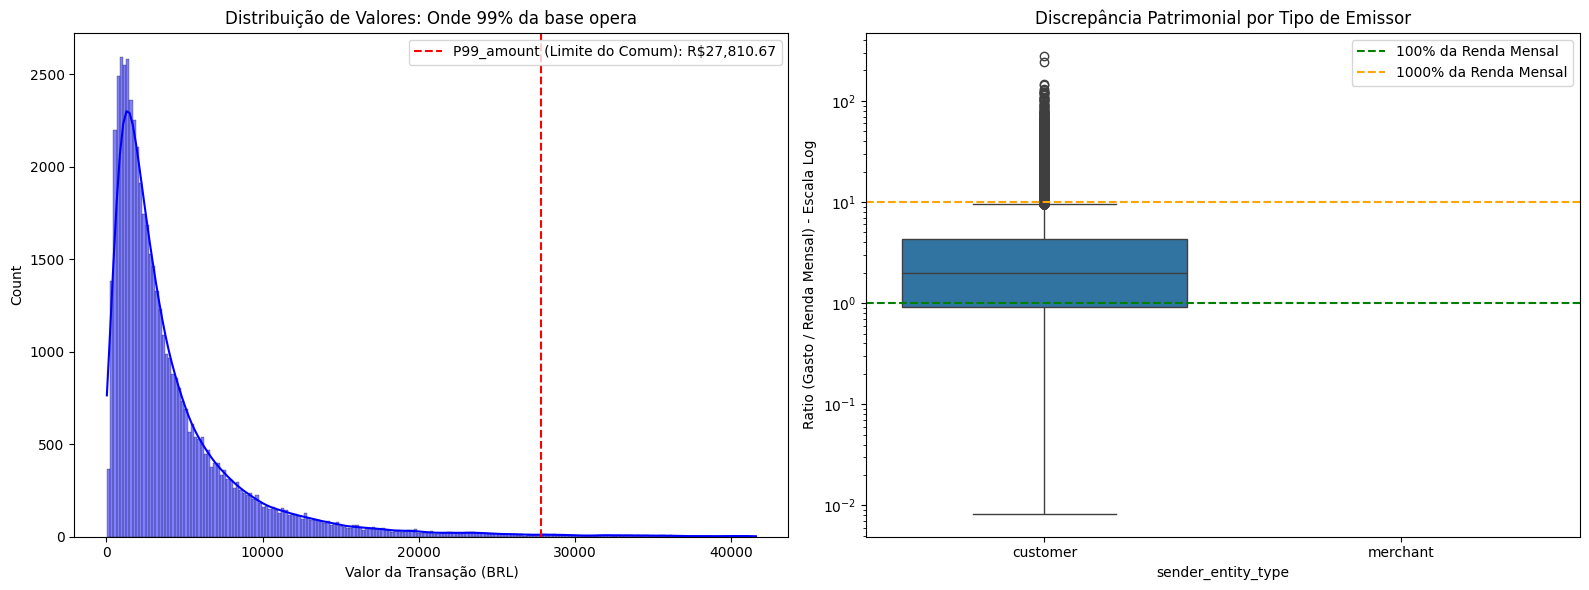

In [7]:
#Visualização do Padrão vs. Red Flags
plt.figure(figsize=(16, 6))

# Gráfico 1: Distribuição de Valores (com corte no P99_amount para visualização melhor)
plt.subplot(1, 2, 1)
P99_amount = stats_amount['99%']
sns.histplot(df_amount_baseline[df_amount_baseline['amount_brl'] < P99_amount * 1.5]['amount_brl'], kde=True, color='blue')
plt.axvline(P99_amount, color='red', linestyle='--', label=f'P99_amount (Limite do Comum): R${P99_amount:,.2f}')
plt.title('Distribuição de Valores: Onde 99% da base opera')
plt.xlabel('Valor da Transação (BRL)')
plt.legend()

# Gráfico 2: Utilização de Renda (Escala Logarítmica para destacar Outliers)
plt.subplot(1, 2, 2)
sns.boxplot(x='sender_entity_type', y='income_utilization', data=df_amount_baseline)
plt.yscale('log') # Escala log é essencial para ver quem gasta 100x o salário
plt.axhline(1, color='green', linestyle='--', label='100% da Renda Mensal')
plt.axhline(10, color='orange', linestyle='--', label='1000% da Renda Mensal')
plt.title('Discrepância Patrimonial por Tipo de Emissor')
plt.ylabel('Ratio (Gasto / Renda Mensal) - Escala Log')
plt.legend()

plt.tight_layout()
plt.show()

- Os dados não seguem uma distribuição normal, pois são enviesados à direita
- Por isso, o método IRQ (interquartile Range) é uma boa opção para identificar outliers

In [8]:
# Função simples para calcular os limites IQR
def get_iqr_bounds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    return upper_bound

In [9]:
# Calculando os limites superiores
ub_amount = get_iqr_bounds(df_amount_baseline['amount_brl'])
ub_ratio = get_iqr_bounds(df_amount_baseline['income_utilization'])

print(f"Threshold estatístico para Valor: R$ {ub_amount:.2f}")
print(f"Threshold estatístico para Ratio de Renda: {ub_ratio:.2f}")


Threshold estatístico para Valor: R$ 11106.32
Threshold estatístico para Ratio de Renda: 9.52


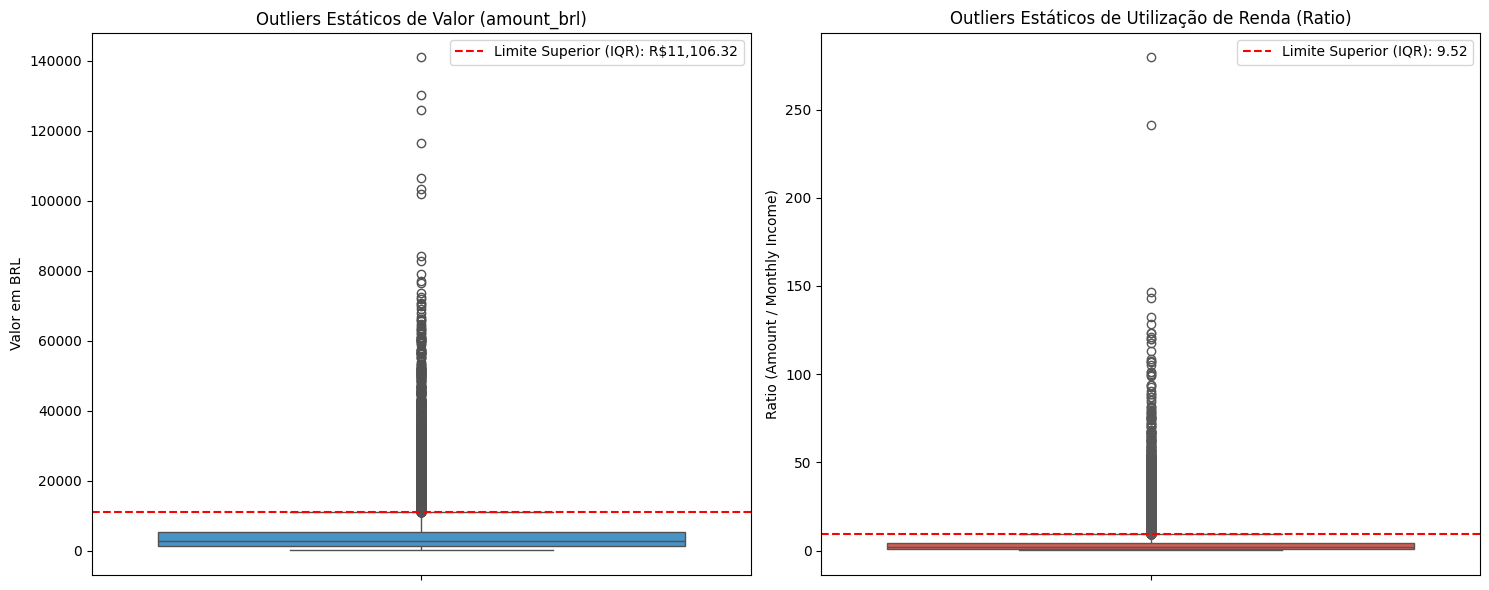

In [10]:
# Visualização com Boxplots
plt.figure(figsize=(15, 6))

# Boxplot para Amount BRL
plt.subplot(1, 2, 1)
sns.boxplot(y=df_amount_baseline['amount_brl'], color='#3498db')
plt.axhline(ub_amount, color='red', linestyle='--', label=f'Limite Superior (IQR): R${ub_amount:,.2f}')
plt.title('Outliers Estáticos de Valor (amount_brl)')
plt.ylabel('Valor em BRL')
plt.legend()

# Boxplot para Ratio de Renda
plt.subplot(1, 2, 2)
sns.boxplot(y=df_amount_baseline['income_utilization'].dropna(), color='#e74c3c')
plt.axhline(ub_ratio, color='red', linestyle='--', label=f'Limite Superior (IQR): {ub_ratio:.2f}')
plt.title('Outliers Estáticos de Utilização de Renda (Ratio)')
plt.ylabel('Ratio (Amount / Monthly Income)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
df_amount_outliers = conn.execute(f"""
    SELECT 
        transaction_id,
        sender_id,
        receiver_id,                   
        amount_brl,
        sender_income,
        sender_occupation,
        -- Criando o ratio de utilização da renda no ato para o baseline
        amount_brl / NULLIF(sender_income / 12.0, 0) AS income_utilization,
        sender_entity_type,
        transaction_type
    FROM transactions_enriched
    WHERE amount_brl > {ub_amount} OR (amount_brl / NULLIF(sender_income / 12.0, 0)) > {ub_ratio} 
    ORDER BY income_utilization DESC
""").df()

#Exemplo de transações que ultrapassaram os limites estatísticos
df_amount_outliers.head()


,transaction_id,sender_id,receiver_id,amount_brl,sender_income,sender_occupation,income_utilization,sender_entity_type,transaction_type
0,TSFBYSDK4OHYP,C100054,M200031,106455.07,4570,Store Owner,279.531912,customer,Card
1,T0DRC3F09C53E,C100857,M200142,49462.79,2461,Designer,241.183860,customer,PIX
2,T599PH2GUH19N,C100462,M200541,56537.09,4636,Chef,146.342770,customer,PIX
3,T35U775Y32FFT,C100117,M200247,116387.08,9753,Software Engineer,143.201575,customer,Card
4,TZTHYDPTZVH8E,C100630,M200870,36887.23,3345,Mechanic,132.330870,customer,Card


| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base| Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|---------|-----------------------------------|
| 1 | High Value Tx | Transação individual acima do P99 da base. | > R$ 27.800,00 | TSFBYSDK4OHYP / C100054 | Transações de valor extremo que fogem do padrão de consumo da base. Valores outliers podem indicar tentativas de movimentação rápida de grandes quantias antes de bloqueio de conta comprometida, ou teste de limites transacionais para fraudes subsequentes. |
| 2 | Income Incompatible Tx | Razão entre o valor da transação e a renda mensal declarada acima do padrão esperado. | amount_brl / monthly_income > 9.52 | TSFBYSDK4OHYP / C100054 | Incompatibilidade patrimonial severa. Transações que excedem múltiplas vezes a capacidade financeira do titular sugerem uso de conta-laranja, credenciais roubadas, ou fraude de identidade sintética. Padrão comum em contas recém-abertas utilizadas para lavagem de dinheiro. |

In [12]:
# Criação da tabela transactions_with_features para adicionar features de transações suspeitas
conn.execute(f"""
CREATE OR REPLACE TABLE transactions_with_features AS
SELECT
  t.*,
  (t.amount_brl / NULLIF(t.sender_income / 12.0, 0)) AS f_income_utilization,
  (t.amount_brl > {P99_amount}) AS f_is_high_value_tx,
  ((t.amount_brl / NULLIF(t.sender_income / 12.0, 0)) > {ub_ratio}) AS f_is_income_incompatible
FROM transactions_enriched t;
""")

#### **2.2. Análise Temporal**

In [13]:
# Consulta para análise temporal (hora do dia)
df_temporal_baseline = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        receiver_id,
        timestamp,
        -- Extraindo a hora do dia
        EXTRACT(HOUR FROM timestamp) AS tx_hour,
        amount_brl,
        sender_entity_type
    FROM transactions_enriched
""").df()

df_temporal_baseline.head(3)

,transaction_id,sender_id,receiver_id,timestamp,tx_hour,amount_brl,sender_entity_type
0,TB9YE5TCX4DFA,C101373,M200001,2025-09-04 13:14:11,13,12521.40,customer
1,TC5IQX2AEGP8T,C101829,M200002,2025-07-30 16:21:21,16,1011.23,customer
2,T03AXHTMB1PQC,C101926,M200002,2025-07-12 21:25:42,21,4855.88,customer


In [14]:
# Função para classificar o período do dia
def get_period(hour):
    if 6 <= hour < 12: return 'Manhã'
    elif 12 <= hour < 18: return 'Tarde'
    elif 18 <= hour < 23: return 'Noite'
    else: return 'Madrugada'

In [15]:
# Cálculo de Estatísticas Temporais
df_temporal_baseline['periodo'] = df_temporal_baseline['tx_hour'].apply(get_period)
distribuicao_temporal = df_temporal_baseline['periodo'].value_counts(normalize=True) * 100

print("--- Distribuição de Transações por Período (%) ---")
print(distribuicao_temporal.round(2))

--- Distribuição de Transações por Período (%) ---
periodo
Madrugada    29.37
Manhã        24.96
Tarde        24.90
Noite        20.78
Name: proportion, dtype: float64


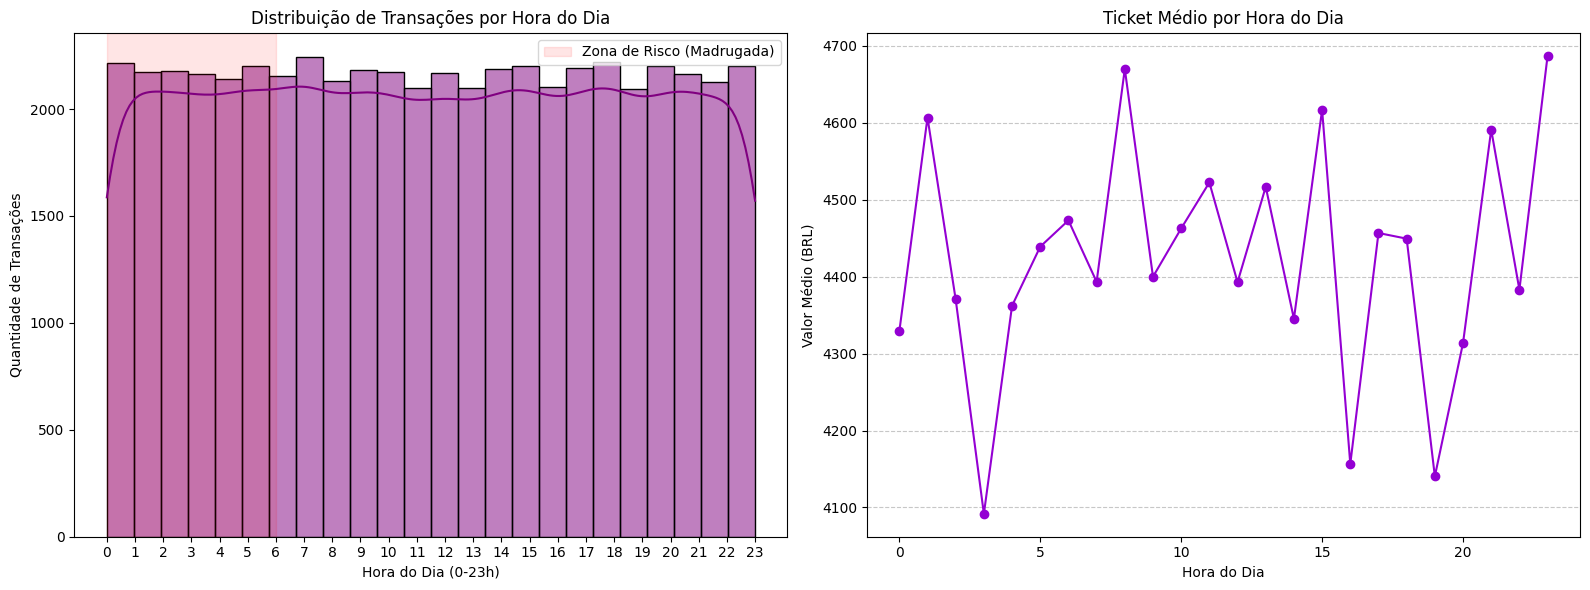

In [16]:
# Visualização do Padrão Temporal
plt.figure(figsize=(16, 6))

# Gráfico 1: Volume de transações por hora (Linha do Tempo de 24h)
plt.subplot(1, 2, 1)
sns.histplot(df_temporal_baseline['tx_hour'], bins=24, kde=True, color='purple')
plt.axvspan(0, 6, color='red', alpha=0.1, label='Zona de Risco (Madrugada)')
plt.xticks(range(0, 24))
plt.title('Distribuição de Transações por Hora do Dia')
plt.xlabel('Hora do Dia (0-23h)')
plt.ylabel('Quantidade de Transações')
plt.legend()

# Gráfico 2: Valor Médio Transacionado por Hora
plt.subplot(1, 2, 2)
avg_amount_hour = df_temporal_baseline.groupby('tx_hour')['amount_brl'].mean()
plt.plot(avg_amount_hour.index, avg_amount_hour.values, marker='o', color='darkviolet')
plt.title('Ticket Médio por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Valor Médio (BRL)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

O baseline temporal revela uma anomalia estrutural na base: o período da madrugada (00h-06h) concentra 29,37% das transações, superando o volume do horário comercial.

Entretanto, utilizar apenas o critério temporal como gatilho gera excesso de falsos positivos, capturando perfis legítimos como trabalhadores noturnos, profissionais de saúde, logística e público jovem com hábitos de consumo digital na madrugada.

Para aumentar a precisão, adota-se abordagem multifatorial: horário atípico combinado com MCC de alto risco.

In [17]:
df_temporal_anomalies = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        receiver_id,
        timestamp,
        EXTRACT(HOUR FROM timestamp) AS tx_hour,
        sender_occupation,
        sender_country,
        receiver_country,
        transaction_type,
        channel,
        amount_brl,
        sender_entity_type,
        status,
        receiver_mcc_risk
    FROM transactions_enriched
    WHERE EXTRACT(HOUR FROM timestamp) BETWEEN 0 AND 6 AND receiver_mcc_risk = 'High'
    ORDER BY amount_brl DESC
""").df()

# Exemplos de transações suspeitas por horário (madrugada)
df_temporal_anomalies.head()

,transaction_id,sender_id,receiver_id,timestamp,tx_hour,sender_occupation,sender_country,receiver_country,transaction_type,channel,amount_brl,sender_entity_type,status,receiver_mcc_risk
0,TEI875SULB85O,C101631,M200300,2025-07-23 05:14:53,5,Dentist,BR,BR,PIX,API,72513.98,customer,Confirmed,High
1,TFRV02TQBTSAE,C100327,M200271,2025-08-20 01:51:46,1,Student,BR,BR,Card,API,69953.51,customer,Confirmed,High
2,T39KTAJ519AX8,C101135,M200113,2025-08-12 01:32:41,1,Chef,BR,PT,PIX,API,46492.33,customer,Confirmed,High
3,T7GLU8BCO7FO3,C100030,M200612,2025-08-16 04:03:14,4,Trader,BR,BR,Card,Web,45442.61,customer,Confirmed,High
4,TAVCYFPYPDRME,C102424,M200169,2025-09-29 06:08:36,6,Designer,BR,BR,Card,Web,45318.87,customer,Pending,High


| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 3 | Unusual Hour Tx | Transações realizadas em horário de baixa atividade legítima (madrugada). | 00h00 - 06h00 E receiver_mcc_risk = 'High' | TEI875SULB85O / C101631 | Padrão comportamental atípico associado a tentativas de evitar detecção ou monitoramento em tempo real. Fraudadores exploram janelas de menor vigilância humana e atrasos em sistemas de resposta a incidentes. |

#### **2.3. Canal e produto**

In [18]:
# Consulta para análise de canal e método de pagamento
df_channel_baseline = conn.execute("""
    SELECT 
        transaction_id,
        transaction_type,
        channel,
        payment_method,
        pix_flow,
        amount_brl,
        status
    FROM transactions_enriched
""").df()

In [19]:
# Estatísticas de Distribuição por Canal
dist_metodo = df_channel_baseline['transaction_type'].value_counts(normalize=True) * 100
dist_fluxo_pix = df_channel_baseline['pix_flow'].value_counts(normalize=True) * 100

print("--- Distribuição por Tipo de Transação (%) ---")
print(dist_metodo.round(2))

print("\n--- Distribuição de Fluxo PIX (%) ---")
print(dist_fluxo_pix.round(2))



--- Distribuição por Tipo de Transação (%) ---
transaction_type
PIX     60.67
Card    34.48
Wire     4.85
Name: proportion, dtype: float64

--- Distribuição de Fluxo PIX (%) ---
pix_flow
cash_out    89.94
cash_in     10.06
Name: proportion, dtype: float64


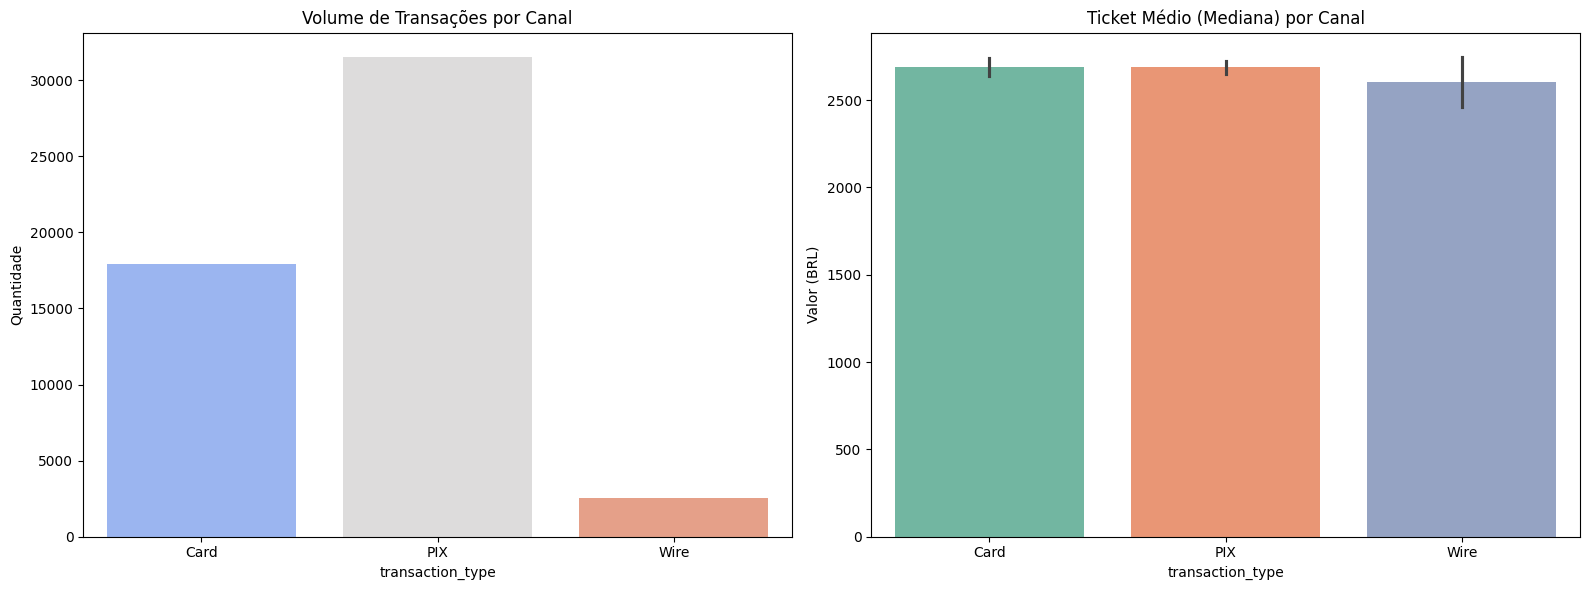

In [20]:
# Visualização do Padrão de Canais
plt.figure(figsize=(16, 6))

# Gráfico 1: Volume por Canal
plt.subplot(1, 2, 1)
sns.countplot(x='transaction_type', data=df_channel_baseline, palette='coolwarm')
plt.title('Volume de Transações por Canal')
plt.ylabel('Quantidade')

# Gráfico 2: Ticket Médio por Canal (Para identificar onde o "dinheiro grosso" passa)
plt.subplot(1, 2, 2)
sns.barplot(x='transaction_type', y='amount_brl', data=df_channel_baseline, estimator='median', palette='Set2')
plt.title('Ticket Médio (Mediana) por Canal')
plt.ylabel('Valor (BRL)')

plt.tight_layout()
plt.show()

In [21]:
df_status_dist = df_channel_baseline.groupby(['transaction_type', 'status']).size().unstack(fill_value=0)

# Convertendo para percentual para normalizar a comparação entre canais
df_status_pct = df_status_dist.div(df_status_dist.sum(axis=1), axis=0) * 100

print("--- Distribuição Percentual de Status por Canal ---")
display(df_status_pct.round(2))


--- Distribuição Percentual de Status por Canal ---


status,Chargeback,Confirmed,Failed,Pending
transaction_type,,,,
Card,2.08,91.92,2.00,3.99
PIX,2.04,91.92,2.10,3.94
Wire,2.06,91.76,2.02,4.16


A taxa de chargeback em transações com cartão de crédito está elevada, 
superando os limites estabelecidos pelas principais bandeiras (Visa: 1,0% 
e Mastercard: 1,5%).

### **Detecção de tipologias**

#### **2.4. Países de riscos**
identifica transações que envolvem jurisdições com deficiência estratégicas no combate à lavagem de dinheiro 

In [22]:
# Consulta para análise de risco de sanções e países de risco
df_country_risk = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        sender_name,
        sender_country,
        receiver_id,
        receiver_name,
        receiver_country,
        amount_brl,
        country_risk_sender,
        country_risk_receiver,
        CAST(cross_border AS INT) AS is_cross_border,
        transaction_type,
        status
    FROM transactions_enriched
    WHERE country_risk_sender = 'High' 
       OR country_risk_receiver = 'High'
""").df()

#Exemplos de transações com risco de sanções ou países de risco
df_country_risk.head()

,transaction_id,sender_id,sender_name,sender_country,receiver_id,receiver_name,receiver_country,amount_brl,country_risk_sender,country_risk_receiver,is_cross_border,transaction_type,status
0,TJ7EXMXX4OUDV,C100435,Customer 436,BR,M200086,Merchant 87,KP,3686.80,Low,High,1,Card,Confirmed
1,T9F7OXP6CUBGM,C100027,Customer 28,BR,M200086,Merchant 87,KP,9657.14,Low,High,1,PIX,Confirmed
2,T6DFDYEG8B0U2,C100050,Customer 51,BR,M200086,Merchant 87,KP,7322.00,Low,High,1,PIX,Confirmed
3,TFCD3ZTPH1SXK,C100190,Customer 191,BR,M200105,Merchant 106,KP,4860.49,Low,High,1,Card,Confirmed
4,T8SKXSSKSY9HK,C100487,Customer 488,BR,M200105,Merchant 106,KP,1219.34,Low,High,1,PIX,Confirmed


In [23]:
# Estatísticas Gerais da Tipologia
high_risk_flow = df_country_risk['amount_brl'].sum()


total_cb = df_country_risk['is_cross_border'].sum()
high_val_cb = len(df_country_risk[(df_country_risk['is_cross_border'] == 1) & 
                                   (df_country_risk['amount_brl'] > ub_amount)])

print(f"--- Resumo de Risco por país ---")
print(f"Volume financeiro em Jurisdições de Alto Risco: R$ {high_risk_flow:,.2f}")
print(f"Quantidade de transações críticas identificadas: {len(df_country_risk)}")

print(f"Quantidade de transações Cross-border em áreas de risco: {total_cb}")
print(f"Transações Cross-border de Alto Valor (>P99): {high_val_cb}")

--- Resumo de Risco por país ---
Volume financeiro em Jurisdições de Alto Risco: R$ 2,508,347.63
Quantidade de transações críticas identificadas: 590
Quantidade de transações Cross-border em áreas de risco: 590
Transações Cross-border de Alto Valor (>P99): 40


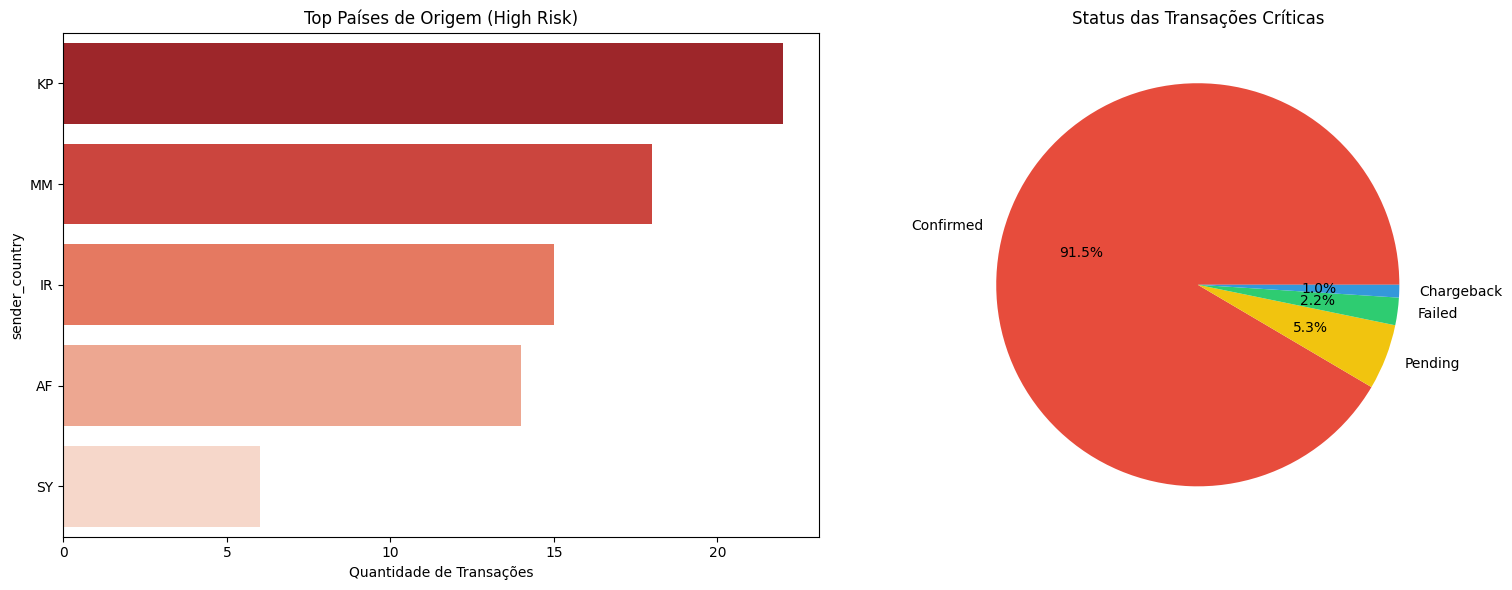

In [24]:
# Visualização de Risco por País
plt.figure(figsize=(16, 6))

# Gráfico 1: Origem vs Destino em Países High Risk
plt.subplot(1, 2, 1)
top_sender_countries = df_country_risk[df_country_risk['country_risk_sender'] == 'High']['sender_country'].value_counts().head(5)
top_receiver_countries = df_country_risk[df_country_risk['country_risk_receiver'] == 'High']['receiver_country'].value_counts().head(5)

sns.barplot(x=top_sender_countries.values, y=top_sender_countries.index, palette='Reds_r')
plt.title('Top Países de Origem (High Risk)')
plt.xlabel('Quantidade de Transações')

# Gráfico 2: Status das Transações de Alto Risco
plt.subplot(1, 2, 2)
df_country_risk['status'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#e74c3c', '#f1c40f', '#2ecc71', '#3498db'])
plt.title('Status das Transações Críticas')
plt.ylabel('')

plt.tight_layout()
plt.show()

Volume significativo (R$ 2,5M+) com alta taxa de aprovação (91%) indica exposição regulatória.

| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 4 | High-Risk Jurisdiction Tx | Transações envolvendo países classificados como alto risco pelo GAFI (Financial Action Task Force). | country_risk_sender = 'High' ou country_risk_receiver = 'High' | TJ7EXMXX4OUDV / C100435 | Jurisdições de alto risco apresentam controles AML/CFT deficientes, facilitando lavagem de dinheiro, financiamento ao terrorismo e evasão de sanções.|
| 5 | High-Value Crossborder | Transações internacionais de alto valor acima do P99 da base. | is_crossborder = True E amount_brl > R$ 27.800,00  | TJ7EXMXX4OUDV / C100435 | Transações internacionais de alto valor indica possível estruturação para evasão de divisas, lavagem de dinheiro transnacional ou financiamento ilícito. Padrão atípico que requer investigação aprofundada sobre origem e destino dos recursos. |

#### **2.5. Listas restritivas e sanções internacionais**
Identifica risco de exposição da instituição a penalidades ao identificar indíviduos, entidades ou jurisdições sob sanções internacionais

In [25]:
# Consulta para análise de risco de sanções
df_sanctions_risk = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        sender_name,
        sender_country,
        receiver_id,
        receiver_name,
        receiver_country,
        amount_brl,
        country_risk_sender,
        country_risk_receiver,
        CAST(cross_border AS INT) AS is_cross_border,
        transaction_type,
        sender_sanctions_hit,
        receiver_sanctions_hit,
        sanctions_screening_hit,
        status
    FROM transactions_enriched
    WHERE sender_sanctions_hit = True 
       OR receiver_sanctions_hit = True
       OR sanctions_screening_hit = True
""").df()

#Exemplos de transações com risco de sanções
df_sanctions_risk.head()

,transaction_id,sender_id,sender_name,sender_country,receiver_id,receiver_name,receiver_country,amount_brl,country_risk_sender,country_risk_receiver,is_cross_border,transaction_type,sender_sanctions_hit,receiver_sanctions_hit,sanctions_screening_hit,status
0,T5AUSU6UFHMD3,C100840,Customer 841,BR,M200038,Merchant 39,US,6637.26,Low,Low,1,PIX,True,<NA>,False,Confirmed
1,TX110NUZ368F6,C101582,Customer 1583,BR,M200093,Merchant 94,BR,1257.37,Low,Low,0,PIX,True,<NA>,False,Confirmed
2,TEX0GENR1NSQ1,C100099,Customer 100,BR,M200334,Merchant 335,US,429.90,Low,Low,1,PIX,True,<NA>,False,Confirmed
3,TJRKHTP81JROK,C100091,Customer 92,BR,M200363,Merchant 364,IR,11672.88,Low,High,1,Wire,False,<NA>,True,Confirmed
4,T2BCS8Z11QBWG,C100840,Customer 841,BR,M200440,Merchant 441,BR,4043.79,Low,Low,0,PIX,True,<NA>,False,Confirmed


In [26]:
# Estatísticas Gerais - Risco de Sanções
total_sanctions = len(df_sanctions_risk)
total_value = df_sanctions_risk['amount_brl'].sum()

sender_sanctions = df_sanctions_risk['sender_sanctions_hit'].sum()
receiver_sanctions = df_sanctions_risk['receiver_sanctions_hit'].sum()
screening_sanctions = df_sanctions_risk['sanctions_screening_hit'].sum()

pct_sender = (sender_sanctions / total_sanctions * 100)
pct_receiver = (receiver_sanctions / total_sanctions * 100)
pct_screening = (screening_sanctions / total_sanctions * 100)

print(f"--- Resumo de Risco de Sanções ---")
print(f"Quantidade de transações com sanções: {total_sanctions:,}")
print(f"Valor total em risco: R$ {total_value:,.2f}")
print()
print(f"Sanções no Remetente: {sender_sanctions:,} ({pct_sender:.1f}%)")
print(f"Sanções no Destinatário: {receiver_sanctions:,} ({pct_receiver:.1f}%)")
print(f"Sanções no Screening: {screening_sanctions:,} ({pct_screening:.1f}%)")

--- Resumo de Risco de Sanções ---
Quantidade de transações com sanções: 220
Valor total em risco: R$ 877,216.20

Sanções no Remetente: 167 (75.9%)
Sanções no Destinatário: 51 (23.2%)
Sanções no Screening: 2 (0.9%)


| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 6 | Sanctions risk | Correspondência direta com listas de sanções internacionais (OFAC, ONU, UE). | sender_sanctions_hit = True OR receiver_sanctions_hit = True OR sanctions_screening_hit = True | T5AUSU6UFHMD3 / C100840 | Transações com entidades sancionadas expõem a instituição a penalidades severas, perda de correspondentes bancários e riscos reputacionais. |

#### **2.6. PEP de alto risco**
PEP - Pessoas políticamente expostas. Indivíduo que desempenhou funções públicas relevantes nos últimos 5 anos. Podem possuir acesso a recursos públicos, poder de influência em decisões governamentais e maior exposição a corrupção



In [27]:
# Consulta para análise de risco de PEPs
df_pep_risk = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        receiver_id,
        sender_occupation,
        CAST(sender_pep AS INT) AS sender_is_pep,
        CAST(sender_pep AS INT) AS receiver_is_pep,
        sender_risk_rating,
        receiver_risk_rating,
        mcc,
        receiver_mcc_risk,
        amount_brl,
        amount_brl / NULLIF(sender_income / 12.0, 0) AS income_utilization,
        status   
    FROM transactions_enriched
    WHERE (sender_pep = True AND sender_risk_rating = 'High') 
       OR (receiver_pep = True AND receiver_risk_rating = 'High')
""").df()

#Exemplos de transações com risco de PEP
df_pep_risk.head()

,transaction_id,sender_id,receiver_id,sender_occupation,sender_is_pep,receiver_is_pep,sender_risk_rating,receiver_risk_rating,mcc,receiver_mcc_risk,amount_brl,income_utilization,status
0,TVBSF6A0ET7FI,C100365,M200634,Freelancer,1,1,High,None,5411,Normal,7403.91,12.921309,Confirmed
1,TZ3T3RQIFTOO3,C101200,M200917,Student,1,1,High,None,5999,Normal,2932.52,2.370032,Pending
2,TUT13LBV8GJK0,C101166,M200075,Software Engineer,1,1,High,None,6011,High,880.07,0.976499,Confirmed
3,T1305FFFUWY4W,C100285,M200463,Freelancer,1,1,High,None,4111,Normal,3926.80,1.785788,Confirmed
4,TCD90TNC8GBFR,C101166,M200712,Software Engineer,1,1,High,None,4111,Normal,3006.36,3.335767,Confirmed


In [28]:
# Estatísticas Gerais da Tipologia
total_pep_risk = len(df_pep_risk)
volume_pep_risk = df_pep_risk['amount_brl'].sum()
avg_utilization_pep = df_pep_risk['income_utilization'].mean()

print(f"--- Resumo PEP de alto risco ---")
print(f"Total de transações PEP de alto risco: {total_pep_risk}")
print(f"Volume financeiro total: R$ {volume_pep_risk:,.2f}")
print(f"Utilização de renda média nestas transações: {avg_utilization_pep:.2f}x")

--- Resumo PEP de alto risco ---
Total de transações PEP de alto risco: 121
Volume financeiro total: R$ 480,433.07
Utilização de renda média nestas transações: 3.66x


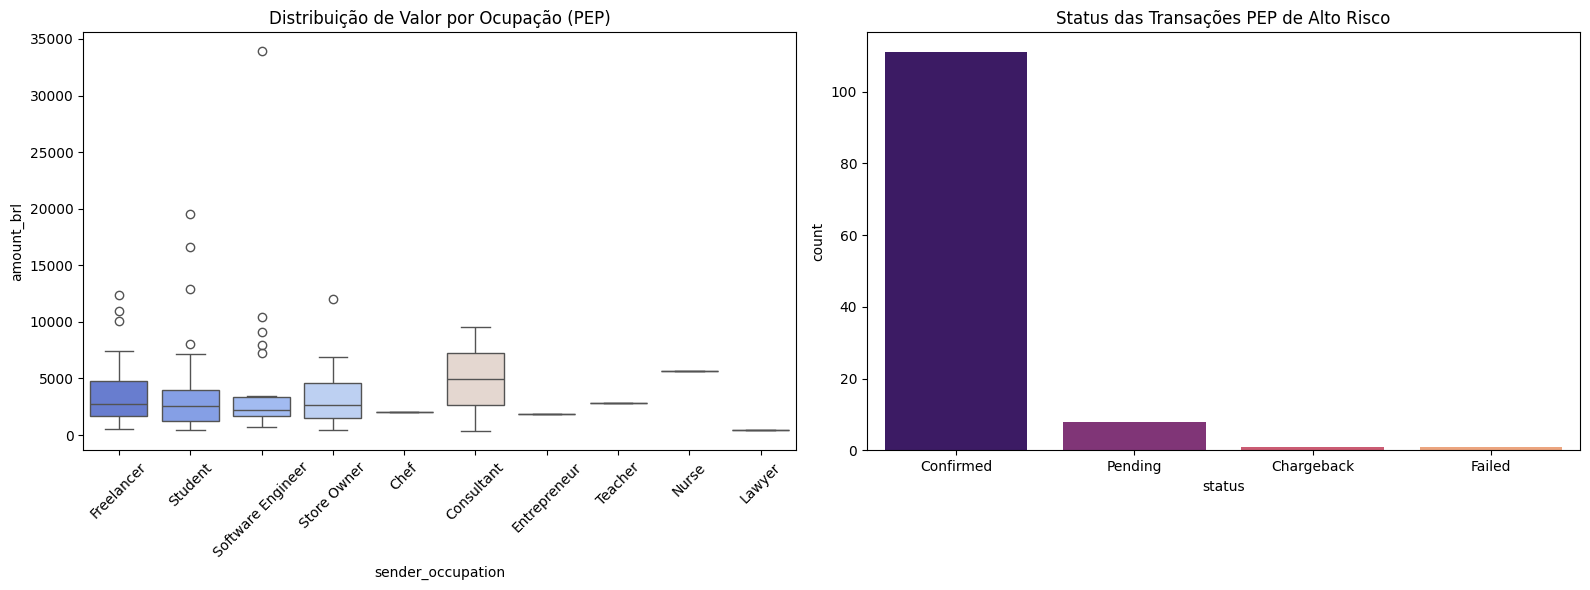

In [29]:
# Visualização de Concentração por Ocupação e Setor
plt.figure(figsize=(16, 6))

# Gráfico 1: Valor Transacionado por Ocupação do PEP
plt.subplot(1, 2, 1)
sns.boxplot(x='sender_occupation', y='amount_brl', data=df_pep_risk, palette='coolwarm')
plt.title('Distribuição de Valor por Ocupação (PEP)')
plt.xticks(rotation=45)

# Gráfico 2: Proporção de Status (Barra)
plt.subplot(1, 2, 2)
sns.countplot(x='status', data=df_pep_risk, palette='magma')
plt.title('Status das Transações PEP de Alto Risco')

plt.tight_layout()
plt.show()

| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 7 | High-Risk PEP Transaction | Transações de Pessoas Politicamente Expostas (PEP) classificadas como alto risco. | sender_pep = True E sender_risk_rating = 'High' OU receiver_pep = True E receiver_risk_rating = 'High' | TVBSF6A0ET7FI / C100365 | PEPs de alto risco possuem acesso privilegiado a recursos públicos e poder de influência em decisões governamentais, apresentando maior exposição a corrupção, peculato e lavagem de dinheiro de origem ilícita. Requerem Enhanced Due Diligence (EDD) obrigatória conforme Resolução CVM 50/2021 e Circular BCB 3.978/2020. |

#### **2.7. MCC de alto risco**

MCC é um código de 4 dígitos que classifica o tipo de negócio do estabelecimento comercial. Criado pelas bandeiras (Visa/Mastercard) para categorizar transações. Setores de alto risco são aqueles de difícl rastreamento e propícios para lavagem de dinheiro.

In [30]:
# Consulta para análise de risco de MCCs
df_mcc_risk = conn.execute("""
    SELECT 
        transaction_id,
        sender_id,
        receiver_id,
        mcc,
        receiver_mcc_risk,
        amount_brl,
        amount_brl / NULLIF(sender_income / 12.0, 0) AS income_utilization,
        status   
    FROM transactions_enriched
    WHERE receiver_entity_type = 'merchant' AND receiver_mcc_risk = 'High'
""").df()

# Exemplos de transações com risco de MCC
df_mcc_risk.head()

,transaction_id,sender_id,receiver_id,mcc,receiver_mcc_risk,amount_brl,income_utilization,status
0,TB9YE5TCX4DFA,C101373,M200001,7995,High,12521.40,4.387316,Confirmed
1,TQXF3QDH8C6RT,C101339,M200004,6051,High,19812.87,27.100700,Confirmed
2,TCV13CGIDJTWF,C101488,M200004,6051,High,2498.24,1.220440,Confirmed
3,T1YHZ8Z190J39,C101708,M200004,6051,High,1092.07,1.110768,Confirmed
4,TOXVAXKX1L83I,C100311,M200005,6051,High,2841.70,1.794852,Confirmed


In [31]:
# Estatísticas Gerais da Tipologia
total_mcc_risk = len(df_mcc_risk)
volume_mcc_risk = df_mcc_risk['amount_brl'].sum()
avg_utilization_mcc = df_mcc_risk['income_utilization'].mean()

print(f"--- Resumo mcc de alto risco ---")
print(f"Total de transações mcc de alto risco: {total_mcc_risk}")
print(f"Volume financeiro total: R$ {volume_mcc_risk:,.2f}")
print(f"Utilização de renda média nestas transações: {avg_utilization_mcc:.2f}x")

--- Resumo mcc de alto risco ---
Total de transações mcc de alto risco: 13800
Volume financeiro total: R$ 61,053,078.31
Utilização de renda média nestas transações: 3.95x


| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 8 | High-Risk MCC Transaction | Transações com estabelecimentos comerciais classificados em categorias de alto risco. | receiver_entity_type = 'merchant' E receiver_mcc_risk = 'High' | TB9YE5TCX4DFA / C101373 | MCCs de alto risco (ex: casas de câmbio, joalherias, cassinos, criptomoedas) apresentam dificuldade de rastreamento e são historicamente explorados para layering e placement em esquemas de lavagem de dinheiro. Setores com alta liquidez, anonimato transacional e conversibilidade rápida em ativos fungíveis requerem monitoramento intensificado.|

#### **2.8. Self merchant**

Ocorre quando um emissor (sender) realiza pagamentos para um estabelecimento comercial (merchant) do qual ele mesmo é proprietário ou sócio

In [32]:
# Consulta para análise de transações onde o sender é o próprio dono do merchant (auto-pagamento)
df_self_merchant = conn.execute("""
    SELECT 
        transaction_id,
        timestamp,
        sender_id,
        sender_name,
        receiver_id,
        receiver_name,
        amount_brl,
        status,
        transaction_type,
        sender_occupation,
        -- Verificando se o dono do Merchant é o próprio Sender
        CASE 
            WHEN sender_id = receiver_merchant_owner_id THEN 'Self-Payment'
            ELSE 'Third-Party'
        END AS ownership_link,
        receiver_mcc_risk,
        sender_income
    FROM transactions_enriched
    WHERE sender_id = receiver_merchant_owner_id 
""").df()

#Exemplos de transações onde o sender é o próprio dono do merchant (auto-pagamento)
df_self_merchant.head()

,transaction_id,timestamp,sender_id,sender_name,receiver_id,receiver_name,amount_brl,status,transaction_type,sender_occupation,ownership_link,receiver_mcc_risk,sender_income
0,T89LY8D0GYY1H,2025-07-24 19:39:28,C102253,Customer 2254,M200083,Merchant 84,13698.06,Confirmed,PIX,Dentist,Self-Payment,High,25794
1,TV86RFT5MA1C2,2025-07-14 04:42:59,C100300,Customer 301,M200137,Merchant 138,7229.05,Confirmed,Wire,Student,Self-Payment,Normal,29374


In [33]:
# Estatísticas Gerais da Tipologia
total_self_merch = len(df_self_merchant)
volume_self_merch = df_self_merchant['amount_brl'].sum()
avg_self_merch = df_self_merchant['amount_brl'].mean()

print(f"--- Alerta de Autofaturamento (Self-Merchant) ---")
print(f"Total de transações 'Dono -> Própria Empresa': {total_self_merch}")
print(f"Volume financeiro total movimentado: R$ {volume_self_merch:,.2f}")
print(f"Ticket médio das operações: R$ {avg_self_merch:,.2f}")

--- Alerta de Autofaturamento (Self-Merchant) ---
Total de transações 'Dono -> Própria Empresa': 2
Volume financeiro total movimentado: R$ 20,927.11
Ticket médio das operações: R$ 10,463.56


| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 9 | Self-Merchant Tx | Transações onde o remetente é o proprietário do estabelecimento recebedor. | sender_id = receiver_merchant_owner_id | T89LY8D0GYY1H / C102253 | Prática utilizada para simular vendas legítimas e justificar entrada de dinheiro ilícito. Permite saque disfarçado via cartão de crédito, burla de limites de crédito, fraude em programas de cashback/fidelidade e criação artificial de histórico transacional para layering em esquemas de lavagem de dinheiro. |

#### **2.9. Segurança em E-commerce (Vulnerabilidade ECI)**
Identifica transações não-presenciais (Card Not Present - CNP) que operam sem camadas de autenticação robustas. O monitoramento utiliza o indicador ECI (Electronic Commerce Indicator), que é retornado pelo protocolo 3D Secure e classifica o nível de autenticação da transação conforme os padrões das bandeiras (Visa/Mastercard).

In [34]:
# Consulta para análise de risco de ECI em transações de cartão de crédito no canal E-commerce
df_ecommerce_eci_risk = conn.execute("""
    SELECT 
        transaction_id,
        timestamp,
        sender_id,
        sender_name,
        amount_brl,
        status,
        card_brand,
        eci,
        receiver_name,
        CASE 
            WHEN eci = 7 THEN 'Vulnerável (ECI 07)'
            WHEN eci IS NULL THEN 'ECI Ausente'
            ELSE 'Autenticada/Não vulnerável'
        END AS eci_risk_level
    FROM transactions_enriched
    WHERE capture_method IN ('E-commerce', 'MOTO')
      AND payment_method = 'credit'
        AND (eci = 7 OR eci IS NULL)                             
""").df()

#Exempos de transações com risco de ECI
df_ecommerce_eci_risk.head()



,transaction_id,timestamp,sender_id,sender_name,amount_brl,status,card_brand,eci,receiver_name,eci_risk_level
0,TJ247LM6VZMW3,2025-09-28 13:56:30,C100482,Customer 483,1907.25,Confirmed,Mastercard,7.0,Merchant 4,Vulnerável (ECI 07)
1,TVCLX91OOG79Z,2025-08-22 23:10:50,C101993,Customer 1994,7077.21,Confirmed,Mastercard,7.0,Merchant 19,Vulnerável (ECI 07)
2,TE9SEP3BPIH09,2025-08-05 18:30:00,C100614,Customer 615,8241.25,Confirmed,Mastercard,7.0,Merchant 33,Vulnerável (ECI 07)
3,TAG9PIZPJSL5E,2025-08-20 02:09:05,C100085,Customer 86,2268.71,Confirmed,Mastercard,7.0,Merchant 78,Vulnerável (ECI 07)
4,T6L8F33T8XL8G,2025-09-19 14:58:08,C102253,Customer 2254,2170.46,Confirmed,Mastercard,7.0,Merchant 95,Vulnerável (ECI 07)


In [35]:
# Estatísticas de Exposição
stats_eci = df_ecommerce_eci_risk['eci_risk_level'].value_counts(normalize=True) * 100

print("--- Composição de Vulnerabilidade no E-commerce (ECI) ---")
print(stats_eci.round(2))

volume_vulneravel = df_ecommerce_eci_risk[
    df_ecommerce_eci_risk['eci_risk_level'] == 'Vulnerável (ECI 07)'
]['amount_brl'].sum()

print(f"\nVolume Financeiro em Risco (ECI Vulnerável): R$ {volume_vulneravel:,.2f}")

--- Composição de Vulnerabilidade no E-commerce (ECI) ---
eci_risk_level
Vulnerável (ECI 07)    100.0
Name: proportion, dtype: float64

Volume Financeiro em Risco (ECI Vulnerável): R$ 10,717,515.49


Observa-se que 66% das transações de e-commercer operam com ECI classificado como vulnerável, indicando que a maioria do volume transacional ocorre fora dos fluxos de autenticação forte

| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 10 | ECI Vulnerable Tx | Transações e-commerce/MOTO com ECI indicando ausência de autenticação 3DS. | capture_method IN ('E-commerce', 'MOTO') E payment_method = 'credit' E eci = 7 | TJ247LM6VZMW3 / C100482 | ECI 07 indica transação não autenticada, aumentando risco de fraude com cartão roubado/clonado. Ausência de ECI sugere falha no processo de autenticação. Transações CNP (Card Not Present) sem autenticação forte são alvo prioritário de fraudadores e geram alto índice de chargeback. |

#### **2.10. IP Anomaly/Proxy Detection**

Identifica ocultação de localização geográfica em transações financeiras

In [36]:
# Consulta para análise de comportamento anômalo de IP
df_ip_anomalies = conn.execute("""
    SELECT
        transaction_id,
        sender_id,
        receiver_id,
        timestamp,
        ip_country,
        ip_proxy_vpn_tor,
        amount_brl,
        status
    FROM transactions_enriched
    WHERE ip_proxy_vpn_tor IS NOT NULL
    ORDER BY amount_brl DESC
""").df()

#Exemplos de transações com comportamento anômalo de IP
df_ip_anomalies.head()
   

,transaction_id,sender_id,receiver_id,timestamp,ip_country,ip_proxy_vpn_tor,amount_brl,status
0,T9BW0FU9UUKMI,C101939,M200498,2025-09-21 15:47:28,BR,Proxy,61106.44,Confirmed
1,TBTDZAOAW7U06,C100885,M200630,2025-07-13 03:50:46,BR,Tor,53423.40,Confirmed
2,T3R40VWJJYQRF,C100761,M200114,2025-07-02 17:28:14,BR,VPN,51941.02,Confirmed
3,T1ZZ2NGY96BRB,C102295,M200464,2025-09-02 00:56:04,BR,VPN,51811.01,Confirmed
4,T4V2RUH0PWVW4,C102018,M200252,2025-08-29 00:03:10,BR,Proxy,48584.70,Confirmed


In [37]:
total_spent_anomalies = df_ip_anomalies['amount_brl'].sum()
total_count_anomalies = len(df_ip_anomalies)
avg_amount_anomalies = df_ip_anomalies['amount_brl'].mean()

print(f"--- Estatísticas de Anomalias de IP (Proxy/VPN/TOR) ---")
print(f"Total Transacionado: R$ {total_spent_anomalies:,.2f}")
print(f"Quantidade de Transações: {total_count_anomalies}")
print(f"Ticket Médio: R$ {avg_amount_anomalies:,.2f}")

--- Estatísticas de Anomalias de IP (Proxy/VPN/TOR) ---
Total Transacionado: R$ 16,438,878.55
Quantidade de Transações: 3663
Ticket Médio: R$ 4,487.82


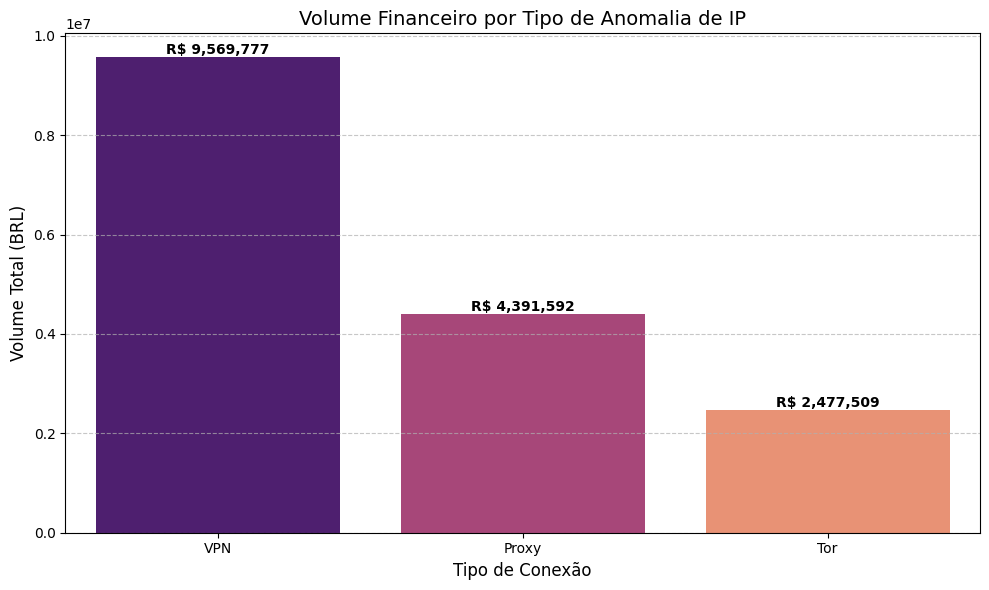

In [38]:
# Agrupamento por tipo de anomalia para o gráfico
volume_by_ip_type = df_ip_anomalies.groupby('ip_proxy_vpn_tor')['amount_brl'].sum().sort_values(ascending=False)

# Geração do Gráfico de Barras Verticais
plt.figure(figsize=(10, 6))
sns.barplot(x=volume_by_ip_type.index, y=volume_by_ip_type.values, palette='magma')

# Customização do Gráfico
plt.title('Volume Financeiro por Tipo de Anomalia de IP', fontsize=14)
plt.xlabel('Tipo de Conexão', fontsize=12)
plt.ylabel('Volume Total (BRL)', fontsize=12)
plt.xticks(rotation=0) # Mantém as labels na vertical se forem curtas
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionando labels de valor sobre as barras
for i, value in enumerate(volume_by_ip_type.values):
    plt.text(i, value, f'R$ {value:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 11| Anonymized IP Transaction | Transações originadas de endereços IP identificados como proxy, VPN ou rede Tor. | ip_proxy_vpn_tor IN ('vpn', 'proxy', 'tor') | T9BW0FU9UUKMI / C101939 | Uso de ferramentas de anonimização indica intenção deliberada de ocultar localização geográfica real. Padrão comum em fraudes sofisticadas, Account Takeover (ATO), lavagem de dinheiro e evasão de controles geográficos. Dificulta rastreabilidade e investigação forense, elevando risco de não conformidade com políticas KYC/AML. |

#### **2.11. Geo-Salto (Impossible Travel)**

Identifica transações realizadas por um mesmo usuário em localizações geográficas diferentes em um intervalo de tempo tão curto que seria fisicamente impossível viajar entre elas

In [39]:
# Consulta para análise de comportamento geográfico (geo leap)
df_geo_leap = conn.execute("""
    WITH geo_lag AS (
    SELECT 
        transaction_id,
        timestamp,
        sender_id,
        sender_name,
        ip_country,
        amount_brl,
        status,
        LAG(ip_country) OVER (PARTITION BY sender_id ORDER BY timestamp) AS last_ip_country,
        LAG(timestamp) OVER (PARTITION BY sender_id ORDER BY timestamp) AS last_timestamp
    FROM transactions_enriched
)
SELECT 
    *,
    (EXTRACT(EPOCH FROM timestamp) - EXTRACT(EPOCH FROM last_timestamp)) / 60 AS minutes_since_last_tx
FROM geo_lag
WHERE ip_country != last_ip_country
  AND last_timestamp IS NOT NULL  -- Evita erros na primeira transação
  AND (EXTRACT(EPOCH FROM timestamp) - EXTRACT(EPOCH FROM last_timestamp)) / 60 < 240
""").df()

#Exemplos de transações com comportamento geográfico suspeito (geo leap)
df_geo_leap.head()

,transaction_id,timestamp,sender_id,sender_name,ip_country,amount_brl,status,last_ip_country,last_timestamp,minutes_since_last_tx
0,TXV168TWIFHQG,2025-07-23 04:03:55,C100138,Customer 139,ES,8949.32,Failed,BR,2025-07-23 00:22:21,221.566667
1,TLTR0B629SB5A,2025-08-03 17:48:22,C100427,Customer 428,KP,1072.98,Confirmed,BR,2025-08-03 14:59:02,169.333333
2,TX7RBEO3HTJV8,2025-09-20 08:45:02,C101040,Customer 1041,BR,2267.83,Confirmed,US,2025-09-20 05:16:10,208.866667
3,TNZL4AYUUC405,2025-08-17 04:39:37,C100759,Customer 760,BR,1154.14,Confirmed,IQ,2025-08-17 02:47:25,112.200000
4,T73IVDY4CC9U0,2025-09-01 04:17:26,C102109,Customer 2110,IQ,3342.04,Confirmed,BR,2025-09-01 00:51:01,206.416667


In [40]:
# Estatísticas de Geo-Salto
total_leaps = len(df_geo_leap)
critical_leaps = df_geo_leap[df_geo_leap['minutes_since_last_tx'] < 30].shape[0]

print(f"--- Análise de Geo-Salto (Impossible Travel) ---")
print(f"Total de saltos geográficos suspeitos: {total_leaps}")
print(f"Casos críticos (Salto entre países em < 30 min): {critical_leaps}")

--- Análise de Geo-Salto (Impossible Travel) ---
Total de saltos geográficos suspeitos: 42
Casos críticos (Salto entre países em < 30 min): 4


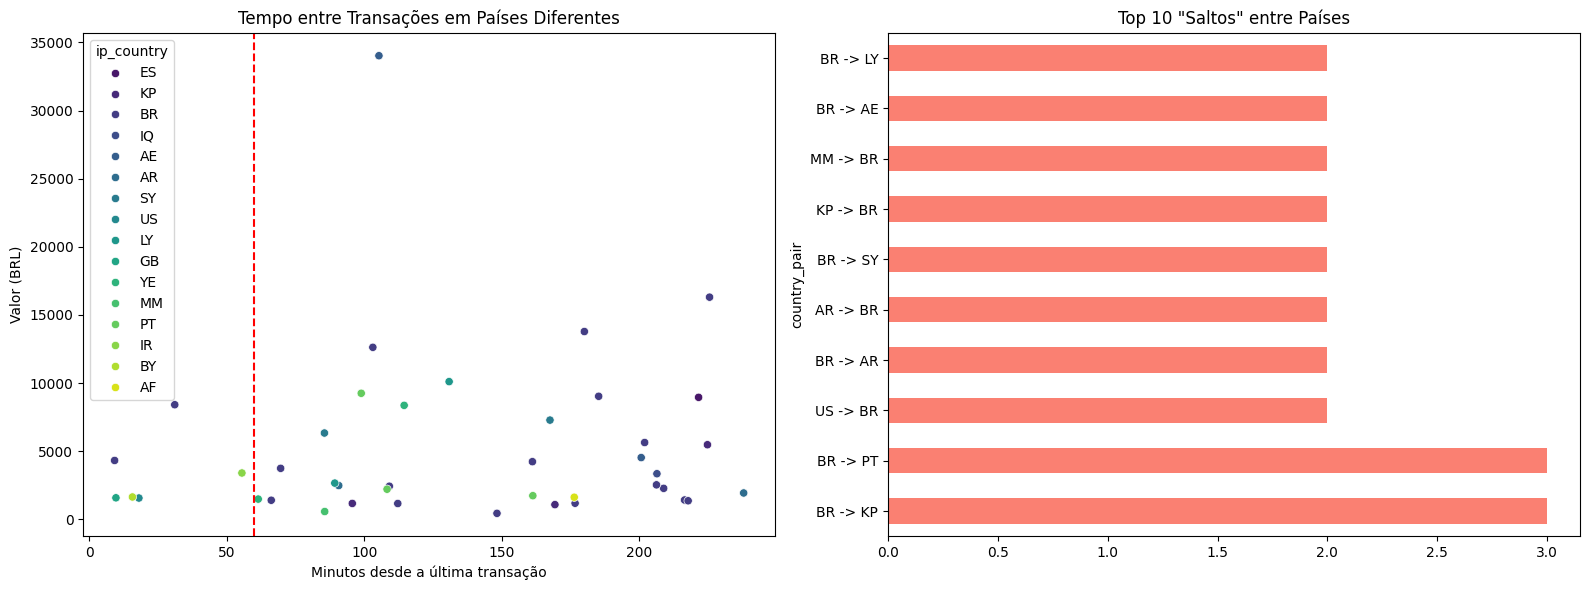

In [41]:
# Visualização: Tempo vs. Mudança de Localidade
plt.figure(figsize=(16, 6))

# Gráfico 1: Dispersão do Tempo de "Viagem"
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_geo_leap, x='minutes_since_last_tx', y='amount_brl', hue='ip_country', palette='viridis')
plt.axvline(60, color='red', linestyle='--', label='Limite 1 Hora')
plt.title('Tempo entre Transações em Países Diferentes')
plt.xlabel('Minutos desde a última transação')
plt.ylabel('Valor (BRL)')

# Gráfico 2: Fluxos de Países Suspeitos
plt.subplot(1, 2, 2)
df_geo_leap['country_pair'] = df_geo_leap['last_ip_country'] + " -> " + df_geo_leap['ip_country']
df_geo_leap['country_pair'].value_counts().head(10).plot(kind='barh', color='salmon')
plt.title('Top 10 "Saltos" entre Países')

plt.tight_layout()
plt.show()

| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 12| Geo-Impossible Velocity | Transações consecutivas do mesmo usuário originadas de países distintos em intervalo de tempo fisicamente impossível. | ip_country ≠ last_ip_country E minutes_since_last_tx < 240 (4 horas) E transações do mesmo sender_id | TXV168TWIFHQG / C100138 | Indicador forte de Account Takeover (ATO). Impossibilidade física de deslocamento entre países em curto intervalo sugere uso simultâneo por múltiplos dispositivos/IPs. Comum em contas comprometidas onde fraudador opera em paralelo ao titular legítimo, ou uso de proxies/VPNs para ocultar origem real da transação. |

#### **2.12. Burst/velocidade**

Identifica picos súbitos de atividades onde um usuário realiza um volume incomum de transações em uma janela de tempo curta (segundos ou minutos)

In [42]:
# Consulta para analise de velocidade de transações (burst behavior)
df_bursts = conn.execute("""
    WITH timed_tx AS (
        SELECT 
            transaction_id,
            sender_id,
            sender_name,
            timestamp,
            amount_brl,
            status,
            payment_method,
            device_fingerprint,
            LAG(timestamp) OVER (PARTITION BY sender_id ORDER BY timestamp) AS last_ts
        FROM transactions_enriched
    )
    SELECT 
        sender_id,
        sender_name,
        COUNT(*) AS qtd_burst,
        SUM(amount_brl) AS volume_burst,
        MIN(timestamp) AS inicio_janela,
        MAX(timestamp) AS fim_janela,
        EXTRACT(EPOCH FROM (MAX(timestamp) - MIN(timestamp))) AS duracao_segundos,
        -- Agregações para campos não-chave
        STRING_AGG(DISTINCT payment_method, ', ') AS payment_methods,
        STRING_AGG(DISTINCT device_fingerprint, ', ') AS devices
    FROM timed_tx
    GROUP BY sender_id, sender_name
    HAVING COUNT(*) > 5
    AND EXTRACT(EPOCH FROM (MAX(timestamp) - MIN(timestamp))) < 86.400
    ORDER BY qtd_burst DESC
""").df()

#Exemplos de comportamentos de burst (múltiplas transações em curto período)
df_bursts.head()

,sender_id,sender_name,qtd_burst,volume_burst,inicio_janela,fim_janela,duracao_segundos,payment_methods,devices


Nenhum usuário realizou mais de 5 transações em menos de 1 hora. Mesmo expandindo a janela de análise para até 2 dias, não foram identificadas ocorrências desse padrão.

In [43]:
df_check_burst = conn.execute(f"""
    SELECT 
        *
    FROM geo_behavior
""").df()

display(df_check_burst.describe())

,tx_count,counterparties,avg_amount,tx_window_days,tx_per_day
count,3497.000000,3497.000000,3497.000000,3497.000000,3497.000000
mean,14.869888,14.780955,4440.842671,78.144981,0.193268
std,7.181924,7.118405,1846.630940,17.977910,0.114512
min,1.000000,1.000000,415.320000,1.000000,0.024000
25%,8.000000,8.000000,3352.460000,74.000000,0.128000
50%,16.000000,16.000000,4173.150000,84.000000,0.198000
75%,20.000000,20.000000,5164.820000,90.000000,0.239000
max,36.000000,36.000000,33973.410000,95.000000,2.000000


In [44]:
display(df_check_burst[df_check_burst['tx_per_day'] > 1])

,sender_id,tx_count,counterparties,avg_amount,tx_window_days,tx_per_day
2579,M200080,2,2,4446.81,1,2.0
2585,M200086,2,2,5982.11,1,2.0
3466,M200969,3,3,6728.89,2,1.5


**Conclusão de velocidade**: A ausência de transações que se enquadram na tipologia burst indica que a base não apresenta sinais de ataques automatizados ou scripts de pulverização de alta frequência.

#### **2.13. Device / IP Ring (rede de dispositivos)**

Identifica quando múltiplos senders distintos compartilham o mesmo equipamento ou a mesma conexão de internet

In [45]:
# Consulta para análise de anel de dispositivos (device ring)
df_device_ring = conn.execute("""
    SELECT 
        device_fingerprint,
        COUNT(DISTINCT sender_id) AS qtd_contas_vinculadas,
        LIST(DISTINCT sender_name) AS nomes_no_dispositivo,
        SUM(amount_brl) AS volume_total_dispositivo,
        COUNT(transaction_id) AS total_transacoes_dispositivo,
        MAX(ip_address) AS ip_principal -- Verificando se o IP também é compartilhado
    FROM transactions_enriched
    WHERE device_fingerprint IS NOT NULL
      AND device_fingerprint != ''
    GROUP BY 1
    HAVING COUNT(DISTINCT sender_id) > 1 -- Mais de uma conta por aparelho
    ORDER BY qtd_contas_vinculadas DESC
""").df()

#Exemplos de anel de dispositivos (device ring)
df_device_ring.head()

,device_fingerprint,qtd_contas_vinculadas,nomes_no_dispositivo,volume_total_dispositivo,total_transacoes_dispositivo,ip_principal


In [46]:
df_check_device = conn.execute("""
    SELECT 
        COUNT(*) as total_transacoes,
        COUNT(DISTINCT device_fingerprint) as dispositivos_unicos,
        COUNT(DISTINCT sender_id) as usuarios_unicos,
        SUM(CASE WHEN device_fingerprint IS NULL OR device_fingerprint = '' THEN 1 ELSE 0 END) as devices_vazios
    FROM transactions_enriched
""").df()

display(df_check_device)

,total_transacoes,dispositivos_unicos,usuarios_unicos,devices_vazios
0,52000,52000,3497,0.0


**Conclusão rede de dispositivo**: Há uma cardinalidade de 1:1 entre o volume total de transações e o número de dispositivos únicos (52000). Devido a essa característica da base, a detecção de fraude por compartilhamento de hardware torna-se inviável

#### **2.13. Cash-in -> Cash-out (fluxo de passagem)**
Conta de Passagem (também chamada de conta laranja, conta fantasma ou money mule account) é uma conta bancária ou de pagamento utilizada temporariamente para receber, movimentar e transferir recursos ilícitos, servindo como intermediária entre a origem criminosa do dinheiro e seu destino final.

In [47]:
# Consulta para análise de throughput 
df_pass_through = conn.execute(f"""
    WITH percentil_90 AS (
    SELECT PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY amount_brl) AS limite
    FROM transactions_enriched
),
total_out AS (
    SELECT 
        sender_id AS user_id,
        SUM(amount_brl) AS total_enviado,
        COUNT(transaction_id) AS qtd_envios,
        MIN(timestamp) AS primeira_saida,
        MAX(timestamp) AS ultima_saida,
        COUNT(DISTINCT receiver_id) AS qtd_destinatarios_unicos,
        COUNT(DISTINCT DATE_TRUNC('day', timestamp)) AS dias_ativos_enviando
    FROM transactions_enriched
    WHERE status = 'Confirmed'
    GROUP BY sender_id
),
total_in AS (
    SELECT 
        receiver_id AS user_id,
        SUM(amount_brl) AS total_recebido,
        COUNT(transaction_id) AS qtd_recebimentos,
        MIN(timestamp) AS primeiro_recebimento,
        MAX(timestamp) AS ultimo_recebimento,
        COUNT(DISTINCT sender_id) AS qtd_remetentes_unicos,
        COUNT(DISTINCT DATE_TRUNC('day', timestamp)) AS dias_ativos_recebendo
    FROM transactions_enriched
    WHERE status = 'Confirmed'
    GROUP BY receiver_id
),
user_names AS (
    SELECT DISTINCT ON (user_id)
        user_id,
        nome
    FROM (
        SELECT sender_id AS user_id, sender_name AS nome, timestamp
        FROM transactions_enriched
        UNION ALL
        SELECT receiver_id AS user_id, receiver_name AS nome, timestamp
        FROM transactions_enriched
    ) combined
    ORDER BY user_id, timestamp DESC
)
SELECT 
    i.user_id,
    un.nome AS nome_usuario,
    i.total_recebido,
    o.total_enviado,
    o.total_enviado / NULLIF(i.total_recebido, 0) AS throughput_ratio,
    EXTRACT(EPOCH FROM (o.primeira_saida - i.primeiro_recebimento)) / 3600.0 AS horas_ate_primeiro_repasse,
    ABS(i.total_recebido - o.total_enviado) AS saldo_residual,
    i.qtd_remetentes_unicos,
    o.qtd_destinatarios_unicos
FROM total_in i
JOIN total_out o ON i.user_id = o.user_id
LEFT JOIN user_names un ON i.user_id = un.user_id
CROSS JOIN percentil_90 p
WHERE 
    -- Filtro 1: Simetria ampliada (±10%)
    (o.total_enviado / NULLIF(i.total_recebido, 0)) BETWEEN 0.90 AND 1.10
    
    -- Filtro 2: Top 10% dos volumes
    AND i.total_recebido > p.limite
    
    -- Filtro 3: Repasse em até 72 horas (3 dias)
    AND EXTRACT(EPOCH FROM (o.primeira_saida - i.primeiro_recebimento)) / 3600.0 <= 72
                               
    -- Filtro 4: Só considera se enviou DEPOIS de receber
    AND o.primeira_saida >= i.primeiro_recebimento  -- Só considera se enviou DEPOIS de receber                        

ORDER BY o.qtd_destinatarios_unicos ASC;
""").df()

#Exemplos de comportamentos de throughput (repasse rápido e simétrico)
df_pass_through.head()

,user_id,nome_usuario,total_recebido,total_enviado,throughput_ratio,horas_ate_primeiro_repasse,saldo_residual,qtd_remetentes_unicos,qtd_destinatarios_unicos
0,C101069,Customer 1070,27906.08,26143.99,0.936856,68.319722,1762.09,4,8
1,C101679,Customer 1680,38333.93,39452.97,1.029192,1.953889,1119.04,9,10
2,C102214,Customer 2215,45768.59,44437.95,0.970927,7.663333,1330.64,8,13
3,C101150,Customer 1151,54016.06,57897.42,1.071856,67.965000,3881.36,8,15
4,C100757,Customer 758,87479.84,83569.35,0.955298,0.181944,3910.49,7,16


Perfis compatíveis com negócios legítimos. Não apresentam características de contas laranja clássicas

### **Regras Consolidadas**

Após análise individual de múltiplos aspectos transacionais, foram identificados padrões comportamentais anômalos que demandam monitoramento. A tabela a seguir consolida as regras estabelecidas para detecção e mitigação desses riscos:

| # | Métrica | Definição Técnica | Threshold (Limiar) | Exemplo na base | Justificativa de Risco (Red Flag) |
|---|---------|-------------------|-------------------|-----------------|-----------------------------------|
| 1 | High Value Tx | Transação individual acima do P99 da base. | > R$ 27.800,00 | TSFBYSDK4OHYP / C100054 | Transações de valor extremo que fogem do padrão de consumo da base. Valores outliers podem indicar tentativas de movimentação rápida de grandes quantias antes de bloqueio de conta comprometida, ou teste de limites transacionais para fraudes subsequentes. |
| 2 | Income Incompatible Tx | Razão entre o valor da transação e a renda mensal declarada acima do padrão esperado. | amount_brl / monthly_income > 9.52 | TSFBYSDK4OHYP / C100054 | Incompatibilidade patrimonial severa. Transações que excedem múltiplas vezes a capacidade financeira do titular sugerem uso de conta-laranja, credenciais roubadas, ou fraude de identidade sintética. Padrão comum em contas recém-abertas utilizadas para lavagem de dinheiro. |
| 3 | Unusual Hour Tx | Transações realizadas em horário de baixa atividade legítima (madrugada). | 00h00 - 06h00 E receiver_mcc_risk = 'High' | TEI875SULB85O / C101631 | Padrão comportamental atípico associado a tentativas de evitar detecção ou monitoramento em tempo real. Fraudadores exploram janelas de menor vigilância humana e atrasos em sistemas de resposta a incidentes. |
| 4 | High-Risk Jurisdiction Tx | Transações envolvendo países classificados como alto risco pelo GAFI (Financial Action Task Force). | country_risk_sender = 'High' OU country_risk_receiver = 'High' | TJ7EXMXX4OUDV / C100435 | Jurisdições de alto risco apresentam controles AML/CFT deficientes, facilitando lavagem de dinheiro, financiamento ao terrorismo e evasão de sanções. |
| 5 | High-Value Crossborder | Transações internacionais de alto valor acima do P99 da base. | is_crossborder = True E amount_brl > R$ 27.800,00 | TJ7EXMXX4OUDV / C100435 | Transações internacionais de alto valor indicam possível estruturação para evasão de divisas, lavagem de dinheiro transnacional ou financiamento ilícito. Padrão atípico que requer investigação aprofundada sobre origem e destino dos recursos. |
| 6 | Sanctions Risk | Correspondência direta com listas de sanções internacionais (OFAC, ONU, UE). | sender_sanctions_hit = True OU receiver_sanctions_hit = True OU sanctions_screening_hit = True | T5AUSU6UFHMD3 / C100840 | Transações com entidades sancionadas expõem a instituição a penalidades severas, perda de correspondentes bancários e riscos reputacionais. |
| 7 | High-Risk PEP Transaction | Transações de Pessoas Politicamente Expostas (PEP) classificadas como alto risco. |  sender_pep = True E sender_risk_rating = 'High' OU receiver_pep = True E receiver_risk_rating = 'High' | TVBSF6A0ET7FI / C100365 | PEPs de alto risco possuem acesso privilegiado a recursos públicos e poder de influência em decisões governamentais, apresentando maior exposição a corrupção, peculato e lavagem de dinheiro de origem ilícita. Requerem Enhanced Due Diligence (EDD) obrigatória conforme Resolução CVM 50/2021 e Circular BCB 3.978/2020. |
| 8 | High-Risk MCC Transaction | Transações com estabelecimentos comerciais classificados em categorias de alto risco. | receiver_entity_type = 'merchant' E receiver_mcc_risk = 'High' | TB9YE5TCX4DFA / C101373 | MCCs de alto risco (ex: casas de câmbio, joalherias, cassinos, criptomoedas) apresentam dificuldade de rastreamento e são historicamente explorados para layering e placement em esquemas de lavagem de dinheiro. Setores com alta liquidez, anonimato transacional e conversibilidade rápida em ativos fungíveis requerem monitoramento intensificado. |
| 9 | Self-Merchant Tx | Transações onde o remetente é o proprietário do estabelecimento recebedor. | sender_id = receiver_merchant_owner_id | T89LY8D0GYY1H / C102253 | Prática utilizada para simular vendas legítimas e justificar entrada de dinheiro ilícito. Permite saque disfarçado via cartão de crédito, burla de limites de crédito, fraude em programas de cashback/fidelidade e criação artificial de histórico transacional para layering em esquemas de lavagem de dinheiro. |
| 10 | ECI Vulnerable Tx | Transações e-commerce/MOTO com ECI indicando ausência de autenticação 3DS. | capture_method IN ('E-commerce', 'MOTO') E payment_method = 'credit' E eci = 7 | TJ247LM6VZMW3 / C100482 | ECI 07 indica transação não autenticada, aumentando risco de fraude com cartão roubado/clonado. Ausência de ECI sugere falha no processo de autenticação. Transações CNP (Card Not Present) sem autenticação forte são alvo prioritário de fraudadores e geram alto índice de chargeback. |
| 11 | Anonymized IP Transaction | Transações originadas de endereços IP identificados como proxy, VPN ou rede Tor. | ip_proxy_vpn_tor IN ('vpn', 'proxy', 'tor') | T9BW0FU9UUKMI / C101939 | Uso de ferramentas de anonimização indica intenção deliberada de ocultar localização geográfica real. Padrão comum em fraudes sofisticadas, Account Takeover (ATO), lavagem de dinheiro e evasão de controles geográficos. Dificulta rastreabilidade e investigação forense, elevando risco de não conformidade com políticas KYC/AML. |
| 12 | Geo-Impossible Velocity | Transações consecutivas do mesmo usuário originadas de países distintos em intervalo de tempo fisicamente impossível. | ip_country ≠ last_ip_country E minutes_since_last_tx < 240 (4 horas) E transações do mesmo sender_id | TXV168TWIFHQG / C100138 | Indicador forte de Account Takeover (ATO). Impossibilidade física de deslocamento entre países em curto intervalo sugere uso simultâneo por múltiplos dispositivos/IPs. Comum em contas comprometidas onde fraudador opera em paralelo ao titular legítimo, ou uso de proxies/VPNs para ocultar origem real da transação. |



### **3. Sistema de alertas**

A implementação de um sistema de alertas é importante para operacionalizar a detecção proativa dessas anomalias, permitindo resposta rápida antes da materialização de perdas financeiras ou exposição a riscos regulatórios.

Um sistema de alertas eficaz transforma regras de detecção em mecanismos automatizados de vigilância contínua, reduzindo a dependência de revisões manuais e minimizando a janela de exposição a fraudes.

#### **3.1 Features/Flags (Detecção por Transação)**

Nesta etapa, a tabela transactions_enriched foi transformada em uma camada de features determinísticas transactions_with_features, com flags booleanas (f_is_*) que representam o disparo de cada regra de risco por transação.

A importância dessa camada para o sistema de alertas é que ela funciona como o motor de detecção: padroniza a lógica das regras em um único lugar, torna o processamento reprodutível e auditável, e facilita a explicabilidade (é possível mostrar exatamente quais condições foram atendidas e quais evidências sustentam o alerta).

In [48]:
# Executar a query para criar a tabela com features
conn.execute(f"""
CREATE OR REPLACE TABLE transactions_with_features AS
WITH geo_velocity AS (
    SELECT 
        transaction_id,
        sender_id,
        ip_country,
        timestamp,
        LAG(ip_country) OVER (PARTITION BY sender_id ORDER BY timestamp) AS last_ip_country,
        LAG(timestamp) OVER (PARTITION BY sender_id ORDER BY timestamp) AS last_timestamp
    FROM transactions_enriched
)
SELECT
  t.*,
  
  -- Campos auxiliares de geo_velocity
  gv.last_ip_country,
  gv.last_timestamp,
  (EPOCH(t.timestamp) - EPOCH(gv.last_timestamp)) / 60.0 AS minutes_since_last_tx,
  
  -- Feature 1: Income Utilization
  (t.amount_brl / NULLIF(t.sender_income / 12.0, 0)) AS f_income_utilization,
  
  -- Feature 2: High Value Transaction
  (t.amount_brl > {P99_amount}) AS f_is_high_value_tx,
  
  -- Feature 3: Income Incompatible
  ((t.amount_brl / NULLIF(t.sender_income / 12.0, 0)) > {ub_ratio}) AS f_is_income_incompatible,
  
  -- Feature 4: Unusual Hour Transaction
  (EXTRACT(HOUR FROM t.timestamp) BETWEEN 0 AND 6 AND t.receiver_mcc_risk = 'High') AS f_is_unusual_hour_tx,
  
  -- Feature 5: High-Risk Jurisdiction Transaction
  (t.country_risk_sender = 'High' OR t.country_risk_receiver = 'High') AS f_is_high_risk_jurisdiction,

   -- Feature 6: Sanctions Risk Transaction
  (t.sender_sanctions_hit = TRUE OR t.receiver_sanctions_hit = TRUE OR t.sanctions_screening_hit = TRUE) AS f_is_sanctions_risk,

  -- Feature 7: High Value Cross-Border Transaction 
  (t.cross_border = TRUE AND t.amount_brl > {P99_amount}) AS f_is_high_value_cross_border,
  
  -- Feature 8: High-Risk PEP Transaction
  ((t.sender_pep = TRUE AND t.sender_risk_rating = 'High') 
   OR (t.receiver_pep = TRUE AND t.receiver_risk_rating = 'High')) AS f_is_high_risk_pep,
  
  -- Feature 9: High-Risk MCC Transaction
  (t.receiver_entity_type = 'merchant' AND t.receiver_mcc_risk = 'High') AS f_is_high_risk_mcc,
  
  -- Feature 10: Self-Merchant Transaction
  (t.sender_id = t.receiver_merchant_owner_id) AS f_is_self_merchant,
  
  -- Feature 11: ECI Vulnerable Transaction
  (t.capture_method IN ('E-commerce', 'MOTO') 
   AND t.payment_method = 'credit' 
   AND t.eci = 7) AS f_is_eci_vulnerable,

  -- Feature 12: Anonymized IP Transaction
  (t.ip_proxy_vpn_tor IS NOT NULL) AS f_is_ip_anomalous,
  
  -- Feature 13: Geo-Impossible Velocity
  (gv.ip_country != gv.last_ip_country 
   AND gv.last_ip_country IS NOT NULL
   AND (EPOCH(t.timestamp) - EPOCH(gv.last_timestamp)) / 60.0 < 240) AS f_is_geo_impossible

FROM transactions_enriched t
LEFT JOIN geo_velocity gv ON t.transaction_id = gv.transaction_id;
""")

# Recuperar a tabela e converter para pandas
df_features = conn.execute("SELECT * FROM transactions_with_features").df()

# Salvar como parquet
df_features.to_parquet('data/processed/transactions_with_features.parquet', index=False)


#### **3.2. Sistema de alertas operacional**

#### **3.2.1. Catálogo de regras**

In [49]:
conn.execute("""
CREATE OR REPLACE TABLE rules_catalog AS
SELECT * FROM (VALUES
  (1,  'High Value Tx',              2),
  (2,  'Income Incompatible Tx',     3),
  (3,  'Unusual Hour Tx',            2),
  (4,  'High-Risk Jurisdiction Tx',  4),
  (5,  'High-Value Crossborder',     3),
  (6,  'Sanctions Risk',             5),
  (7,  'High-Risk PEP Transaction',  4),
  (8,  'High-Risk MCC Transaction',  3),
  (9,  'Self-Merchant Tx',           3),
  (10, 'ECI Vulnerable Tx',          2),
  (11, 'Anonymized IP Transaction',  3),
  (12, 'Geo-Impossible Velocity',    4)
) AS t(rule_id, rule_name, severity);
""")

# Quick check
df_rules = conn.execute("SELECT * FROM rules_catalog ORDER BY rule_id").df()
df_rules.head(12)

,rule_id,rule_name,severity
0,1,High Value Tx,2
1,2,Income Incompatible Tx,3
2,3,Unusual Hour Tx,2
3,4,High-Risk Jurisdiction Tx,4
4,5,High-Value Crossborder,3
5,6,Sanctions Risk,5
6,7,High-Risk PEP Transaction,4
7,8,High-Risk MCC Transaction,3
8,9,Self-Merchant Tx,3
9,10,ECI Vulnerable Tx,2


Essa tabela funciona como fonte de priorização do sistema, garantindo consistencia na classificação de risco e facilitando a manutenção

#### **3.2.2. Geração de alertas**

Tabela de alertas em formato longo: cada linha representa um alerta disparado por uma regra específica

In [50]:
conn.execute("""
CREATE OR REPLACE TABLE alerts AS

-- Regra 1
SELECT
  t.transaction_id,
  t.timestamp,
  1 AS rule_id,
  'High Value Tx' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_high_value_tx

UNION ALL

-- Regra 2
SELECT
  t.transaction_id,
  t.timestamp,
  2 AS rule_id,
  'Income Incompatible Tx' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_income_incompatible

UNION ALL

-- Regra 3
SELECT
  t.transaction_id,
  t.timestamp,
  3 AS rule_id,
  'Unusual Hour Tx' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_unusual_hour_tx

UNION ALL

-- Regra 4
SELECT
  t.transaction_id,
  t.timestamp,
  4 AS rule_id,
  'High-Risk Jurisdiction Tx' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_high_risk_jurisdiction

UNION ALL

-- Regra 5
SELECT
  t.transaction_id,
  t.timestamp,
  5 AS rule_id,
  'High-Value Crossborder' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_high_value_cross_border

UNION ALL

-- Regra 6
SELECT
  t.transaction_id,
  t.timestamp,
  6 AS rule_id,
  'Sanctions Risk' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_sanctions_risk

UNION ALL

-- Regra 7
SELECT
  t.transaction_id,
  t.timestamp,
  7 AS rule_id,
  'High-Risk PEP Transaction' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_high_risk_pep

UNION ALL

-- Regra 8 (sujeito investigado: merchant receiver)
SELECT
  t.transaction_id,
  t.timestamp,
  8 AS rule_id,
  'High-Risk MCC Transaction' AS rule_name,
  'receiver_merchant' AS subject_entity_type,
  t.receiver_merchant_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_high_risk_mcc

UNION ALL

-- Regra 9
SELECT
  t.transaction_id,
  t.timestamp,
  9 AS rule_id,
  'Self-Merchant Tx' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_self_merchant

UNION ALL

-- Regra 10
SELECT
  t.transaction_id,
  t.timestamp,
  10 AS rule_id,
  'ECI Vulnerable Tx' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_eci_vulnerable

UNION ALL

-- Regra 11
SELECT
  t.transaction_id,
  t.timestamp,
  11 AS rule_id,
  'Anonymized IP Transaction' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_ip_anomalous

UNION ALL

-- Regra 12
SELECT
  t.transaction_id,
  t.timestamp,
  12 AS rule_id,
  'Geo-Impossible Velocity' AS rule_name,
  'sender' AS subject_entity_type,
  t.sender_id AS subject_entity_id,
  t.amount_brl,
  t.status
FROM transactions_with_features t
WHERE t.f_is_geo_impossible
;
""")

# Quick checks
df_alerts_sample = conn.execute("""
SELECT *
FROM alerts
ORDER BY timestamp DESC
LIMIT 10
""").df()

df_alerts_sample

,transaction_id,timestamp,rule_id,rule_name,subject_entity_type,subject_entity_id,amount_brl,status
0,TZDX8P5BHHW3G,2025-10-04 23:52:53,7,High-Risk PEP Transaction,sender,C101166,1807.66,Confirmed
1,TBV27TLBXHQLG,2025-10-04 23:51:46,11,Anonymized IP Transaction,sender,C101546,5519.16,Confirmed
2,T1AEUVERKDVQJ,2025-10-04 23:50:12,2,Income Incompatible Tx,sender,C100652,11390.80,Confirmed
3,T1AEUVERKDVQJ,2025-10-04 23:50:12,8,High-Risk MCC Transaction,receiver_merchant,M200084,11390.80,Confirmed
4,TBG18X47WNBI3,2025-10-04 23:50:02,8,High-Risk MCC Transaction,receiver_merchant,M200555,2240.97,Confirmed
5,TF8OYQLRL6MLU,2025-10-04 23:49:12,8,High-Risk MCC Transaction,receiver_merchant,M200996,2738.47,Confirmed
6,T6Z2WDS2ER4H0,2025-10-04 23:48:20,10,ECI Vulnerable Tx,sender,M200547,5261.84,Confirmed
7,TKJUBJDXJHLSX,2025-10-04 23:45:52,8,High-Risk MCC Transaction,receiver_merchant,M200546,1548.06,Confirmed
8,T6J31KNIHFOO6,2025-10-04 23:31:02,2,Income Incompatible Tx,sender,C100857,5990.08,Confirmed
9,T6J31KNIHFOO6,2025-10-04 23:31:02,8,High-Risk MCC Transaction,receiver_merchant,M200198,5990.08,Confirmed


Enriquecimento com severidade do alerta conforme definido no catalogo

In [51]:
conn.execute("""
CREATE OR REPLACE TABLE alerts_enriched AS
SELECT
  a.*,
  r.severity
FROM alerts a
JOIN rules_catalog r USING (rule_id);
""")


df_alerts_enriched = conn.execute("""
SELECT *
FROM alerts_enriched
ORDER BY severity DESC, timestamp DESC
LIMIT 10
""").df()

df_alerts_enriched

,transaction_id,timestamp,rule_id,rule_name,subject_entity_type,subject_entity_id,amount_brl,status,severity
0,TF64XBZY8RNIB,2025-10-04 19:35:17,6,Sanctions Risk,sender,C101445,907.70,Pending,5
1,TO4AF1HZUO0NJ,2025-10-04 06:50:31,6,Sanctions Risk,sender,C100472,17092.60,Confirmed,5
2,TBZO122ZECICC,2025-10-04 02:49:09,6,Sanctions Risk,sender,C100099,1272.83,Confirmed,5
3,TFGYZOCI28X3V,2025-10-03 15:40:59,6,Sanctions Risk,sender,C101517,3216.29,Confirmed,5
4,TVCI2P4GM7SL3,2025-10-03 04:35:22,6,Sanctions Risk,sender,C100046,12010.14,Confirmed,5
5,T54HMUKI3TYZQ,2025-10-02 18:43:14,6,Sanctions Risk,sender,M200639,1309.54,Confirmed,5
6,THINY81EB9N7V,2025-10-01 22:29:58,6,Sanctions Risk,sender,C100840,6261.01,Confirmed,5
7,TARPIXB23P87B,2025-10-01 19:19:57,6,Sanctions Risk,sender,C101582,4002.64,Confirmed,5
8,T02TM1CLMV8RH,2025-10-01 18:45:14,6,Sanctions Risk,sender,C100570,6183.66,Confirmed,5
9,TXRJRNN4GIFFS,2025-10-01 12:38:20,6,Sanctions Risk,sender,C102417,1434.74,Confirmed,5


#### **3.2.3. Resumo por transação (Priorizar as 30 transações mais críticas)**

In [52]:
conn.execute("""
CREATE OR REPLACE TABLE tx_alert_summary AS
SELECT
  t.transaction_id,
  t.timestamp,
  t.sender_id,
  t.receiver_id,
  t.amount_brl,
  t.status,

  COUNT(a.rule_id) AS alert_count,
  MAX(a.severity)  AS max_severity,
  COALESCE(SUM(a.severity), 0) AS weighted_risk_score,

  -- IDs das regras disparadas
  LISTAGG(CAST(a.rule_id AS VARCHAR), ',') AS rule_ids,
  
  -- Nome das regras disparadas
  LISTAGG(a.rule_name) AS rule_names,

FROM transactions_with_features t
LEFT JOIN alerts_enriched a
  ON t.transaction_id = a.transaction_id
GROUP BY 1,2,3,4,5,6;
""")

In [53]:
df_alert_distribution = conn.execute("""
WITH base AS (
    SELECT
        CASE 
            WHEN alert_count > 0 THEN 'Com Alerta' 
            ELSE 'Sem Alerta' 
        END AS categoria,
        alert_count,
        weighted_risk_score,
        max_severity,
        amount_brl
    FROM tx_alert_summary
)

SELECT
    categoria,

    -- Volume
    COUNT(*) AS total_transacoes,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS percentual_transacoes,

    -- Alertas (intensidade)
    AVG(alert_count) AS media_alert_count,
    MIN(alert_count) AS min_alert_count,
    MAX(alert_count) AS max_alert_count,

    -- Score de risco
    ROUND(AVG(weighted_risk_score), 2) AS media_weighted_score,
    MIN(weighted_risk_score) AS min_weighted_score,
    MAX(weighted_risk_score) AS max_weighted_score,

    -- Severidade
    AVG(max_severity) AS media_max_severity,
    MAX(max_severity) AS pico_severidade,

    -- Financeiro
    ROUND(AVG(amount_brl), 2) AS ticket_medio_brl,
    ROUND(SUM(amount_brl), 2) AS volume_financeiro_brl,

    -- Concentração de risco
    ROUND(
        100.0 * SUM(
            CASE WHEN max_severity >= 4 THEN 1 ELSE 0 END
        ) / COUNT(*),
        2
    ) AS pct_transacoes_alta_severidade

FROM base
GROUP BY categoria
ORDER BY total_transacoes DESC;
""").df()

df_alert_distribution

,categoria,total_transacoes,percentual_transacoes,media_alert_count,min_alert_count,max_alert_count,media_weighted_score,min_weighted_score,max_weighted_score,media_max_severity,pico_severidade,ticket_medio_brl,volume_financeiro_brl,pct_transacoes_alta_severidade
0,Sem Alerta,30507,58.67,0.000000,0,0,0.00,0.0,0.0,NaN,<NA>,3427.53,1.045636e+08,0.00
1,Com Alerta,21493,41.33,1.383381,1,6,3.88,2.0,18.0,2.98432,5,5838.84,1.254943e+08,4.49


- 41,33% das transações geraram pelo menos um alerta, enquanto 58,67% não apresentaram nenhum sinal de risco.

- Média de 1,38 regras disparadas por transação, com casos chegando a até 6 alertas simultâneos, o que evidencia convergência de sinais de risco em parte da base.

- O score ponderado médio (3,88) e o pico de score (18) reforçam que existem transações com acúmulo significativo de fatores de risco, justificando priorização investigativa.

In [54]:
df_tx_priority = conn.execute("""
SELECT *
FROM tx_alert_summary
ORDER BY weighted_risk_score DESC, alert_count DESC, amount_brl DESC
LIMIT 30
""").df()

df_tx_priority

,transaction_id,timestamp,sender_id,receiver_id,amount_brl,status,alert_count,max_severity,weighted_risk_score,rule_ids,rule_names
0,T5L6TABCH2AYE,2025-08-02 05:09:07,C100472,M200567,42420.78,Confirmed,6,5,18.0,"11,8,6,3,2,1","Anonymized IP Transaction,High-Risk MCC Transa..."
1,T1T7IVJF50U9P,2025-09-18 06:39:53,C102060,M200438,32269.81,Confirmed,6,4,17.0,"8,5,4,3,2,1","High-Risk MCC Transaction,High-Value Crossbord..."
2,TCZO0UQKXL50K,2025-07-01 06:16:21,C100526,M200227,28737.03,Confirmed,6,3,16.0,"11,8,5,3,2,1","Anonymized IP Transaction,High-Risk MCC Transa..."
3,TFCY8GCSTH9SR,2025-07-27 04:04:09,C101986,M200253,28320.78,Confirmed,6,3,16.0,"11,8,5,3,2,1","Anonymized IP Transaction,High-Risk MCC Transa..."
4,T3J1QOXEGNS0H,2025-08-08 04:34:56,C100237,M200652,30965.16,Confirmed,6,3,15.0,"10,8,5,3,2,1","ECI Vulnerable Tx,High-Risk MCC Transaction,Hi..."
5,T7GLU8BCO7FO3,2025-08-16 04:03:14,C100030,M200612,45442.61,Confirmed,5,5,15.0,"8,6,3,2,1","High-Risk MCC Transaction,Sanctions Risk,Unusu..."
6,T9BW0FU9UUKMI,2025-09-21 15:47:28,C101939,M200498,61106.44,Confirmed,5,3,14.0,"11,8,5,2,1","Anonymized IP Transaction,High-Risk MCC Transa..."
7,TWJZHV8OUESYF,2025-09-23 15:26:08,C100134,M200761,45973.80,Confirmed,5,3,14.0,"11,8,5,2,1","Anonymized IP Transaction,High-Risk MCC Transa..."
8,TW4JMYR62VLOF,2025-09-07 08:05:03,C101213,M200527,41493.97,Confirmed,5,3,14.0,"11,8,5,2,1","Anonymized IP Transaction,High-Risk MCC Transa..."
9,T2XWI49VVPVMT,2025-09-29 06:03:27,C100285,M200076,572.18,Confirmed,5,4,14.0,"11,10,8,7,3","Anonymized IP Transaction,ECI Vulnerable Tx,Hi..."


In [55]:
df_tx_priority['sender_id'].value_counts().head()

sender_id
C100472    2
C100237    2
C100526    1
C102060    1
C101986    1
Name: count, dtype: int64

In [56]:
df_tx_priority['rule_names'].value_counts()

rule_names
High-Risk MCC Transaction,High-Value Crossborder,Unusual Hour Tx,Income Incompatible Tx,High Value Tx                              4
High-Risk MCC Transaction,High-Value Crossborder,Income Incompatible Tx,High Value Tx                                              3
Anonymized IP Transaction,High-Risk MCC Transaction,High-Value Crossborder,Income Incompatible Tx,High Value Tx                    3
High-Value Crossborder,High-Risk Jurisdiction Tx,Income Incompatible Tx,High Value Tx                                              3
ECI Vulnerable Tx,High-Risk MCC Transaction,Unusual Hour Tx,Income Incompatible Tx,High Value Tx                                   3
Anonymized IP Transaction,High-Risk MCC Transaction,High-Value Crossborder,Unusual Hour Tx,Income Incompatible Tx,High Value Tx    2
ECI Vulnerable Tx,High-Risk MCC Transaction,Sanctions Risk,Unusual Hour Tx                                                         2
Anonymized IP Transaction,High-Risk MCC Transaction,Sancti

### **4. Casos suspeitos + SAR**

In [57]:
df_priority_tx_enriched = conn.execute("""
SELECT
    -- Identificação
    s.transaction_id,
    s.timestamp,
    EXTRACT(HOUR FROM s.timestamp) AS tx_hour,
    s.status,

    -- Priorização
    s.alert_count,
    s.max_severity,
    s.weighted_risk_score,
    s.rule_names,

    -- Financeiro
    s.amount_brl,
    

    -- Sender (cliente)
    t.sender_id,
    t.sender_entity_type,
    t.sender_name,
    t.sender_document,
    t.sender_risk_rating,
    t.sender_pep,
    t.sender_kyc_tier,
    t.sender_kyc_score,
    t.sender_income,
    t.sender_sanctions_hit,


    -- Receiver / Merchant
    t.receiver_id,
    t.receiver_entity_type,
    t.receiver_name,
    t.receiver_document,
    t.receiver_merchant_id,
    t.receiver_mcc_risk,
    t.receiver_sanctions_hit,

    -- Pagamento
    t.transaction_type,
    t.channel,
    t.capture_method,
    t.payment_method,
    t.eci,
    t.mcc,

    -- Geo / Técnico
    t.ip_country,
    t.last_ip_country,
    t.minutes_since_last_tx,
    t.ip_proxy_vpn_tor,
    t.cross_border,
    t.sanctions_screening_hit,

    -- Evidência-chave
    t.f_income_utilization

FROM tx_alert_summary s
JOIN transactions_with_features t
  ON s.transaction_id = t.transaction_id
WHERE s.alert_count > 0
ORDER BY
    s.weighted_risk_score DESC,
    s.max_severity DESC,
    s.amount_brl DESC
LIMIT 3
""").df()

df_priority_tx_enriched

,transaction_id,timestamp,tx_hour,status,alert_count,max_severity,weighted_risk_score,rule_names,amount_brl,sender_id,sender_entity_type,sender_name,sender_document,sender_risk_rating,sender_pep,sender_kyc_tier,sender_kyc_score,sender_income,sender_sanctions_hit,receiver_id,receiver_entity_type,receiver_name,receiver_document,receiver_merchant_id,receiver_mcc_risk,receiver_sanctions_hit,transaction_type,channel,capture_method,payment_method,eci,mcc,ip_country,last_ip_country,minutes_since_last_tx,ip_proxy_vpn_tor,cross_border,sanctions_screening_hit,f_income_utilization
0,T5L6TABCH2AYE,2025-08-02 05:09:07,5,Confirmed,6,5,18.0,"Anonymized IP Transaction,High-Risk MCC Transa...",42420.78,C100472,customer,Customer 473,77454803721,Low,False,L1,55,23044,True,M200567,merchant,Merchant 568,42751186101878,M200567,High,<NA>,PIX,API,Pix Key,None,NaN,7995,BR,BR,5370.883333,VPN,False,False,22.090321
1,T1T7IVJF50U9P,2025-09-18 06:39:53,6,Confirmed,6,4,17.0,"High-Risk MCC Transaction,High-Value Crossbord...",32269.81,C102060,customer,Customer 2061,54742291356,Medium,False,L1,76,12035,False,M200438,merchant,Merchant 439,44701340118402,M200438,High,<NA>,PIX,App,Pix Key,None,NaN,7995,BR,BR,4886.050000,None,True,False,32.175963
2,TCZO0UQKXL50K,2025-07-01 06:16:21,6,Confirmed,6,3,16.0,"Anonymized IP Transaction,High-Risk MCC Transa...",28737.03,C100526,customer,Customer 527,34056936961,Low,False,L2,51,10813,False,M200227,merchant,Merchant 228,26733414181179,M200227,High,<NA>,PIX,App,QR Dynamic,None,NaN,6011,BR,None,NaN,Tor,True,False,31.891645


#### **4.1.Top 3 Casos Suspeitos Identificados**

A seguir estão os três casos mais prioritários da base, selecionados com base no weighted_risk_score, severidade máxima, quantidade de alertas simultâneos e materialidade financeira. O objetivo deste resumo é consolidar rapidamente os principais sinais de risco de cada caso, servindo como base direta para escolha e elaboração do SAR.

---

**Caso 1 — Cliente C100472** 
**Transaction ID:** T5L6TABCH2AYE  
**Valor:** R$ 42.420,78  
**Score de Risco:** 18 (máximo da amostra)  
**Severidade Máxima:** 5  
**Qtd. de Alertas:** 6  

**Principais Red Flags:**
- Uso de IP anonimizado (VPN).
- MCC de alto risco no recebedor (Atividades de jogos de azar).
- Renda declarada incompatível com o valor transacionado (income utilization ≈ 22x).
- Transação realizada em horário atípico (05h).
- Sanctions hit no sender, elevando significativamente o risco regulatório.

**Conclusão:**  
Caso crítico com múltiplos sinais convergentes (técnicos, financeiros e regulatórios). Forte candidato a Account Takeover (ATO) ou lavagem via merchant de alto risco, com necessidade de ação imediata.

---

**Caso 2 — Cliente C102060**  
**Transaction ID:** T1T7IVJF50U9P  
**Valor:** R$ 32.269,81  
**Score de Risco:** 17  
**Severidade Máxima:** 4  
**Qtd. de Alertas:** 6  

**Principais Red Flags:**
- Transação cross-border de alto valor.
- MCC de alto risco recebedor (Atividades de jogos de azar).
- Renda incompatível com o valor transacionado (income utilization ≈ 32x).

---

**Caso 3 — Cliente C100526** 
**Transaction ID:** TCZO0UQKXL50K  
**Valor:** R$ 28.737,03  
**Score de Risco:** 16  
**Severidade Máxima:** 3  
**Qtd. de Alertas:** 6  

**Principais Red Flags:**
- Uso de rede Tor (alto grau de anonimização).
- MCC 6011 (instituições financeiras / câmbio), classificado como alto risco.
- Renda incompatível com o valor transacionado (income utilization ≈ 31x).
- Transação cross-border.

**Conclusão:**  
Caso com forte componente técnico (anonimização) combinado a risco setorial (MCC 6011). Menor severidade relativa, mas com padrão típico de ocultação e possível lavagem, justificando investigação aprofundada.

---


#### **4.2. Suspicious Activity Report (SAR)**

Entre os três casos, o Caso 1 (C100472) se destaca como o melhor candidato para SAR, devido a:
- severidade máxima (5),
- presença de sanctions hit,
- múltiplas tipologias simultâneas (ATO, MCC alto risco, renda incompatível),
- e maior impacto financeiro individual.



**1. Identificação do Caso**
- **Cliente (Sender):** C100472 — Customer 473   
- **Transaction ID:** T5L6TABCH2AYE  
- **Período analisado:** 02/08/2025 (evento focal) + histórico recente do cliente  
- **Rails envolvidos:** PIX  
- **Meio/canal:** API / Pix Key  
- **Cross-border:** Não (doméstico)  
- **Entidade recebedora:** Merchant M200567 (MCC classificado como *alto risco*)  

---

**2. Resumo** 
Foi identificada uma transação PIX de *alto valor (R$ 42.420,78)* realizada por cliente pessoa física com *renda declarada incompatível* (income utilization ≈ *22x), em **horário atípico (05h), direcionada a **merchant classificado como alto risco, com MCC dea alto risco (Atividades de jogos de azar), com **uso de IP anonimizado (VPN). O evento concentrou **múltiplos sinais simultâneos* (6 alertas), incluindo *sanctions hit no sender*, elevando substancialmente o risco regulatório.

O padrão observado é consistente com  *lavagem de dinheiro via merchant de alto risco, com possível utilizando PIX para rápida movimentação de valores. Dada a materialidade financeira, a convergência de tipologias e o impacto regulatório associado a sanções, recomenda-se *reporte via SAR, com **ações imediatas de mitigação*.

---

**3. Sinais / Alertas Acionados**
| Regra | Lógica | Data/Hora | Transaction ID |
|---|---|---|---|
| Anonymized IP Transaction | IP identificado como VPN | 02/08/2025 05:09 | T5L6TABCH2AYE |
| High-Risk MCC Transaction | Merchant com MCC de alto risco | 02/08/2025 05:09 | T5L6TABCH2AYE |
| Income Incompatible Tx | amount / renda mensal ≫ limiar | 02/08/2025 05:09 | T5L6TABCH2AYE |
| Unusual Hour Tx | Transação entre 00h–06h | 02/08/2025 05:09 | T5L6TABCH2AYE |
| Sanctions Risk | Sender com sanctions hit | 02/08/2025 05:09 | T5L6TABCH2AYE |
| High Value Tx | Valor acima do P99 da base | 02/08/2025 05:09 | T5L6TABCH2AYE |

*Resumo de priorização:* alert_count = 6, max_severity = 5, weighted_risk_score = 18.

---

**4. Base Legal / Regulatória**
- *FATF/GAFI:* Tipologias de **Layering via meios de pagamento eletrônicos* e *uso de entidades/estabelecimentos de alto risco*.  
- *BACEN (Circular 3.978/2020):* Dever de monitoramento contínuo, EDD e reporte de operações suspeitas.  
- *COAF:* Comunicação de operações suspeitas envolvendo *incompatibilidade patrimonial, **sanções* e *mecanismos de ocultação*.

---

**5. Conclusão e Ações Recomendadas**
*Conclusão:* O caso apresenta *alto risco AML/Fraude, com múltiplas tipologias convergentes, materialidade financeira relevante e **exposição regulatória crítica* devido a sanctions hit.

*Ações recomendadas:*
1. *Reporte imediato via SAR* ao regulador competente.  
2. *Congelamento preventivo* ou restrição temporária da conta (conforme política interna).  
3. *Enhanced Due Diligence (EDD)* do cliente (revalidação de KYC, origem de recursos).  
4. *Monitoramento reforçado* de transações futuras (regras de alta severidade).  
5. *Revisão do merchant recebedor* (avaliação de risco, histórico e vínculos).  
6. *Comunicação interna* às áreas de Risco/Fraude/Compliance para coordenação de resposta.

### **5. Modelo de Machine Learning**

In [58]:
# Utilizar o transactions_with_features como base

df = conn.execute("""
SELECT 
    *
FROM transactions_with_features
""").df()

df.head()

,transaction_id,timestamp,transaction_type,sender_id,sender_entity_type,receiver_id,receiver_entity_type,amount_brl,amount_orig,currency,fx_to_brl,status,channel,capture_method,payment_method,installments,issuing_or_acquiring,pix,pix_flow,card_brand,card_present,auth_3ds,eci,mcc,geo_country,geolocation_lat,geolocation_lon,ip_country,ip_anomaly,ip_proxy_vpn_tor,device_fingerprint,ip_address,device_rooted,sender_country,receiver_country,country_risk_geo,country_risk_ip,country_risk_sender,country_risk_receiver,cross_border,sanctions_screening_hit,sender_name,sender_document,sender_income,sender_occupation,sender_risk_rating,sender_registration_date,sender_pep,sender_kyc_tier,sender_kyc_score,sender_sanctions_hit,sender_dob,sender_merchant_id,sender_merchant_owner_id,sender_merchant_high_risk,sender_chargeback_ratio,sender_mcc_risk,receiver_name,receiver_document,receiver_income,receiver_risk_rating,receiver_pep,receiver_kyc_score,receiver_sanctions_hit,receiver_merchant_id,receiver_merchant_owner_id,receiver_merchant_high_risk,receiver_chargeback_ratio,receiver_mcc_risk,sender_tx_count,sender_counterparties,sender_avg_amount,sender_tx_window_days,sender_tx_per_day,last_ip_country,last_timestamp,minutes_since_last_tx,f_income_utilization,f_is_high_value_tx,f_is_income_incompatible,f_is_unusual_hour_tx,f_is_high_risk_jurisdiction,f_is_sanctions_risk,f_is_high_value_cross_border,f_is_high_risk_pep,f_is_high_risk_mcc,f_is_self_merchant,f_is_eci_vulnerable,f_is_ip_anomalous,f_is_geo_impossible
0,TB9YE5TCX4DFA,2025-09-04 13:14:11,Card,C101373,customer,M200001,merchant,12521.40,12521.40,BRL,1.0,Confirmed,Web,Magstripe,debit,1,acquiring,False,None,Mastercard,True,<NA>,NaN,7995,BR,-29.032076,-38.360873,BR,False,None,s46zr5vn4y4yuevo,235.127.179.215,False,BR,BR,Low,Low,Low,Low,False,False,Customer 1374,98399058768,34248,Lawyer,Low,2024-11-21,False,L2,6,False,1980-04-26,None,None,<NA>,NaN,None,Merchant 2,96297252396610,<NA>,None,<NA>,<NA>,<NA>,M200001,None,False,0.052,High,22,21,3268.37,89,0.247,BR,2025-09-01 22:34:34,3759.616667,4.387316,False,False,False,False,<NA>,False,<NA>,True,<NA>,False,False,False
1,TC5IQX2AEGP8T,2025-07-30 16:21:21,PIX,C101829,customer,M200002,merchant,1011.23,1011.23,BRL,1.0,Confirmed,App,Pix Key,None,1,None,True,cash_out,None,<NA>,<NA>,NaN,5411,BR,-24.800033,-45.358862,BR,False,None,mf1qmz2e4oeb84in,143.248.154.172,False,BR,BR,Low,Low,Low,Low,False,False,Customer 1830,89712231899,15554,Driver,Low,2025-09-23,False,L1,93,False,1974-12-28,None,None,<NA>,NaN,None,Merchant 3,67551536706595,<NA>,None,<NA>,<NA>,<NA>,M200002,C100993,False,0.060,Normal,20,20,3395.56,91,0.220,BR,2025-07-21 00:59:04,13882.283333,0.780170,False,False,False,False,<NA>,False,<NA>,False,False,False,False,False
2,T03AXHTMB1PQC,2025-07-12 21:25:42,PIX,C101926,customer,M200002,merchant,4855.88,4855.88,BRL,1.0,Confirmed,API,QR Static,None,1,None,True,cash_out,None,<NA>,<NA>,NaN,5411,BR,-10.934797,-40.540270,BR,False,None,xk4jctpff4scke8o,157.237.204.168,False,BR,BR,Low,Low,Low,Low,False,False,Customer 1927,21456762743,24710,Nurse,Low,2025-01-10,False,L1,34,False,2004-12-22,None,None,<NA>,NaN,None,Merchant 3,67551536706595,<NA>,None,<NA>,<NA>,<NA>,M200002,C100993,False,0.060,Normal,17,17,3821.45,87,0.195,BR,2025-07-07 22:03:44,7161.966667,2.358177,False,False,False,False,<NA>,False,<NA>,False,False,False,False,False
3,TJ247LM6VZMW3,2025-09-28 13:56:30,Card,C100482,customer,M200003,merchant,1907.25,1907.25,BRL,1.0,Confirmed,Web,E-commerce,credit,1,acquiring,False,None,Mastercard,False,True,7.0,5812,BR,2.740854,-44.339640,BR,False,None,ft0ffb6ls7kb79e6,18.79.218.216,False,BR,BR,Low,Low,Low,Low,False,False,Customer 483,75033747761,20000,Designer,Medium,2024-02-05,False,L1,48,False,1978-12-14,None,None,<NA>,NaN,None,Merchant 4,70151821696287,<NA>,None,<NA>,<NA>,<NA>,M200003,None,False,0.039,Normal,19,18,4457.29,76,0.250,BR,2025-09-28 05:18:55,517.583333,1.144350,False,False,False,False,<NA>,False,<NA>,False,<NA>,True,False,False
4,T9I1WWDFHBRE4,2025-07

In [59]:
# Nova checagem tipo de dados
df['mcc'] = df['mcc'].astype(str)
df['eci'] = df['eci'].astype("Int64").astype(str)

bool_cols = df.select_dtypes(include=["bool", "boolean"]).columns.tolist()
for col in bool_cols:
    df[col] = df[col].astype("boolean")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 90 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   transaction_id                52000 non-null  object        
 1   timestamp                     52000 non-null  datetime64[ns]
 2   transaction_type              52000 non-null  object        
 3   sender_id                     52000 non-null  object        
 4   sender_entity_type            52000 non-null  object        
 5   receiver_id                   52000 non-null  object        
 6   receiver_entity_type          52000 non-null  object        
 7   amount_brl                    52000 non-null  float64       
 8   amount_orig                   52000 non-null  float64       
 9   currency                      52000 non-null  object        
 10  fx_to_brl                     52000 non-null  float64       
 11  status                      

Foram identificados ajustes pontuais, como a conversão de documentos e códigos categóricos (ex.: MCC, ECI) para tipos não numéricos, evitando interpretações indevidas pelo modelo, e padronização da tipagem das novas features.

#### **5.1. Revisão de qualidade dos dados**

In [60]:
missing_values(df)

,Missing Values,Percentage
payment_method,34070,65.519231
issuing_or_acquiring,34070,65.519231
pix_flow,20453,39.332692
card_brand,34070,65.519231
card_present,34070,65.519231
auth_3ds,44905,86.355769
ip_proxy_vpn_tor,48337,92.955769
sender_income,5240,10.076923
sender_occupation,5240,10.076923
sender_risk_rating,5240,10.076923


Como já visto anteriormente, a maior parte dos nulos observados é estrutural e explicável pelo contexto da transação, como tipo de pagamento e disponibilidade de dados cadastrais.

Os nulos carregam informação contextual relevante e serão tratados de forma explícita no pipeline de modelagem, por meio de estratégias que diferenciam ausência de informação de não aplicabilidade.

In [61]:
# Identificar colunas categóricas
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# Cardinalidade
cardinality = (df[cat_cols].nunique().sort_values(ascending=False)
)
cardinality

transaction_id                52000
ip_address                    52000
device_fingerprint            52000
sender_id                      3497
sender_name                    3497
receiver_name                  3485
receiver_id                    3485
receiver_merchant_id           1000
sender_merchant_id              997
receiver_merchant_owner_id      319
sender_merchant_owner_id        317
sender_country                   20
receiver_country                 20
last_ip_country                  20
geo_country                      20
ip_country                       20
sender_occupation                16
mcc                              14
capture_method                   11
card_brand                        5
status                            4
channel                           4
eci                               4
currency                          3
country_risk_ip                   3
receiver_risk_rating              3
transaction_type                  3
sender_kyc_tier             

Variáveis com cardinalidade extremamente alta, como IDs, endereços IP e device fingerprint, serão excluidas do modelo, evitando ruído e memorização.

Variáveis categóricas de baixa e média cardinalidade apresentam alto potencial informativo e serão utilizadas no modelo por meio de estratégias adequadas de encoding.

In [62]:
display(df['transaction_type'].value_counts(normalize=True))
display(df['channel'].value_counts(normalize=True).mul(100).round(2))
display(df['status'].value_counts(normalize=True).mul(100).round(2))

transaction_type
PIX     0.606673
Card    0.344808
Wire    0.048519
Name: proportion, dtype: float64

channel
App         40.18
API         40.08
Terminal     9.92
Web          9.82
Name: proportion, dtype: float64

status
Confirmed     91.92
Pending        3.97
Failed         2.06
Chargeback     2.06
Name: proportion, dtype: float64

In [63]:
cols_to_check = [
    "payment_method",
    "card_brand",
    "card_present",
    "auth_3ds",
    "eci",
    "pix_flow"
]

# Percentual de nulos por transaction_type
nulls_by_type = (
    df.groupby("transaction_type")[cols_to_check]
      .apply(lambda x: x.isna().mean() * 100)
      .round(2)
)

nulls_by_type

,payment_method,card_brand,card_present,auth_3ds,eci,pix_flow
transaction_type,,,,,,
Card,0.0,0.0,0.0,60.43,0.0,100.0
PIX,100.0,100.0,100.0,100.00,0.0,0.0
Wire,100.0,100.0,100.0,100.00,0.0,100.0


#### **5.2 Preparo dos dados e seleção de features**

 **Justificativa da Seleção de Features**

O objetivo do modelo não é identificar fraude de forma determinística, mas sim priorizar transações que fogem do comportamento histórico esperado, direcionando a análise humana para os casos mais relevantes.

Dado o cenário sem rótulos confiáveis de fraude, foi adotada uma abordagem não supervisionada, na qual anomalia é definida como desvio estatístico ou comportamental em relação ao padrão observado na base.

Nesse contexto, as features foram selecionadas para capturar quebras de padrão sob diferentes dimensões, por exemplo:

**1. Intensidade Financeira**

Exemplo: amount_brl_log
Captura desvios de valor relativos, permitindo identificar transações financeiramente atípicas sem que valores extremos dominem o modelo.

**2. Comportamento Histórico do Remetente**

Exemplo: sender_tx_per_day
Permite identificar aumentos súbitos de atividade em relação ao padrão histórico do remetente.

**3. Dinâmica Temporal**

Exemplo: minutes_since_last_tx
Evidencia padrões de velocidade anormais, como bursts transacionais ou encadeamento incomum de operações.

**4. Contexto Operacional de Risco**

Exemplo: sender_chargeback_ratio
Introduz contexto de risco histórico da entidade, permitindo capturar desvios associados a ecossistemas mais instáveis.

**5. Capacidade Econômica Relativa**

Exemplo: f_income_utilization
Mede a relação entre valor transacionado e renda estimada, evidenciando possíveis incompatibilidades econômicas.

**6. Modalidade da Transação**

Exemplo: is_pix_tx
Permite ao modelo aprender normalidade condicional à modalidade, evitando confundir diferenças estruturais com anomalia.

**7. Sinais Operacionais**

Exemplo: ip_anomaly
Atua como sinal fraco, permitindo identificar combinações operacionais raras sem impor regras determinísticas.

**Separação das Heurísticas de Risco (f_is_*)**

As tipologias f_is_* não serão utilizadas no treino do modelo, sendo reservadas apenas para validação fraca posterior, evitando circularidade e viés no aprendizado.

As features selecionadas permitem capturar desvios de valor, comportamento, tempo e contexto, possibilitando a construção de um score explicável e adequado à priorização de transações em um ambiente real de AML.

In [64]:
# Separação das colunas em grupos

# Identificadores (não entram no modelo)
id_cols = [
    "transaction_id", "sender_id", "receiver_id",
    "sender_document", "receiver_document",
    "device_fingerprint", "ip_address",
    "sender_name", "receiver_name"
]

# Variáveis temporais
time_cols = [
    "timestamp", "sender_registration_date",
    "sender_dob", "last_timestamp"
]

# Flags booleanas
bool_cols = df.select_dtypes(include=["boolean"]).columns.tolist()

# Heurísticas de risco (não entram no treino - usadas para validação posterior)
heuristic_cols = [c for c in df.columns if c.startswith("f_is_")]

# Variáveis numéricas
num_cols = df.select_dtypes(include=["int64", "Int64", "float64"]).columns.tolist()

# Remover colunas que não devem entrar como numéricas
num_cols = [c for c in num_cols if c not in id_cols]

# Variáveis categóricas
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c not in id_cols]

In [65]:
# Tratamento de nulos em variáveis categóricas
df[cat_cols] = df[cat_cols].fillna("NA_NOT_APPLICABLE")

num_missing_flags = [f"{c}_missing" for c in num_cols]

for c in num_cols:
    df[f"{c}_missing"] = df[c].isna().astype("int")

Diferenciar "não aplicável" de "informação ausente". 
- Para variáveis categóricas o valor NA_NOT_APPLICABLE preserva a informação contextual. 
- Para numéricas o valor é mantido como NaN acompanhado de uma flag explícita

In [66]:
# Criar feature log
df["amount_brl_log"] = np.log1p(df["amount_brl"])

# Definir num_features_model (inclui amount_brl_log)
num_features_model = [
    "amount_brl_log",
    "sender_tx_count",
    "sender_avg_amount",
    "sender_tx_per_day",
    "sender_counterparties",
    "minutes_since_last_tx",
    "sender_chargeback_ratio",
    "receiver_chargeback_ratio",
    "f_income_utilization"
]

# 3Criar missing flags apenas para as features numéricas do modelo
for c in num_features_model:
    df[f"{c}_missing"] = df[c].isna().astype(int)

Sem transformação de escala os modelos tendem a aprender apenas valores altos como anomalias

In [67]:
df["is_pix_tx"] = (df["transaction_type"] == "PIX").astype(int)
df["is_card_tx"] = (df["transaction_type"] == "Card").astype(int)
df["is_wire_tx"] = (df["transaction_type"] == "Wire").astype(int)

In [68]:
cat_features_model = ["transaction_type", "channel", "payment_method", "card_brand", "sender_entity_type", "receiver_entity_type", "pix_flow"]

df_cat_encoded = pd.get_dummies(df[cat_features_model], prefix=cat_features_model, drop_first=False)

In [69]:
# Garanta que existe missing flag para todas as features numéricas do modelo
for c in num_features_model:
    miss_col = f"{c}_missing"
    if miss_col not in df.columns:
        df[miss_col] = df[c].isna().astype(int)

In [70]:
df[bool_cols] = df[bool_cols].astype("Int64").fillna(0)
bool_cols_model = [c for c in bool_cols if c not in heuristic_cols]

In [71]:
df_model = pd.concat(
    [
        df[num_features_model],
        df[[f"{c}_missing" for c in num_features_model]],
        df[bool_cols_model],
        df[["is_pix_tx", "is_card_tx", "is_wire_tx"]],
        df_cat_encoded
    ],
    axis=1
)

# IsolationForest não aceita NaN
df_model = df_model.fillna(0)

df_model.shape

(52000, 57)

In [72]:
df_model.head()

,amount_brl_log,sender_tx_count,sender_avg_amount,sender_tx_per_day,sender_counterparties,minutes_since_last_tx,sender_chargeback_ratio,receiver_chargeback_ratio,f_income_utilization,amount_brl_log_missing,sender_tx_count_missing,sender_avg_amount_missing,sender_tx_per_day_missing,sender_counterparties_missing,minutes_since_last_tx_missing,sender_chargeback_ratio_missing,receiver_chargeback_ratio_missing,f_income_utilization_missing,pix,card_present,auth_3ds,ip_anomaly,device_rooted,cross_border,sanctions_screening_hit,sender_pep,sender_sanctions_hit,sender_merchant_high_risk,receiver_pep,receiver_sanctions_hit,receiver_merchant_high_risk,is_pix_tx,is_card_tx,is_wire_tx,transaction_type_Card,transaction_type_PIX,transaction_type_Wire,channel_API,channel_App,channel_Terminal,channel_Web,payment_method_NA_NOT_APPLICABLE,payment_method_credit,payment_method_debit,card_brand_Amex,card_brand_Elo,card_brand_Hipercard,card_brand_Mastercard,card_brand_NA_NOT_APPLICABLE,card_brand_Visa,sender_entity_type_customer,sender_entity_type_merchant,receiver_entity_type_customer,receiver_entity_type_merchant,pix_flow_NA_NOT_APPLICABLE,pix_flow_cash_in,pix_flow_cash_out
0,9.435274,22,3268.37,0.247,21,3759.616667,0.0,0.052,4.387316,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False
1,6.919911,20,3395.56,0.220,20,13882.283333,0.0,0.060,0.780170,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True
2,8.488152,17,3821.45,0.195,17,7161.966667,0.0,0.060,2.358177,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True
3,7.553942,19,4457.29,0.250,18,517.583333,0.0,0.039,1.144350,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,True,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True,True,False,False
4,9.343789,22,4632.04,0.247,22,10265.033333,0.0,0.039,9.474155,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True


In [73]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52000 entries, 0 to 51999
Data columns (total 57 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   amount_brl_log                     52000 non-null  float64
 1   sender_tx_count                    52000 non-null  int64  
 2   sender_avg_amount                  52000 non-null  float64
 3   sender_tx_per_day                  52000 non-null  float64
 4   sender_counterparties              52000 non-null  int64  
 5   minutes_since_last_tx              52000 non-null  float64
 6   sender_chargeback_ratio            52000 non-null  float64
 7   receiver_chargeback_ratio          52000 non-null  float64
 8   f_income_utilization               52000 non-null  float64
 9   amount_brl_log_missing             52000 non-null  int64  
 10  sender_tx_count_missing            52000 non-null  int64  
 11  sender_avg_amount_missing          52000 non-null  int

#### **5.3 Treinamento do modelo (Isolation Forest)**

O Isolation Forest foi escolhido por apresentar características particularmente adequadas ao contexto:

- É um modelo não supervisionado, adequado à ausência de rótulos confiáveis
- É robusto a distribuições assimétricas e outliers
- Transações anômalas são isoladas com menos divisões na árvore

In [74]:
X_model = df_model.copy() 

X_model.shape

(52000, 57)

O modelo é treinado utilizando o dataset df_model, construído na etapa anterior, que contém apenas:
- Variáveis numéricas transformadas
- Flags booleanas (0/1)
- Flags explícitas de modalidade
- Variáveis categóricas encodadas
- Indicadores de valores ausentes

Identificadores, variáveis temporais cruas, heurísticas de risco (f_is_*) e variáveis de resultado foram explicitamente excluídos.

In [75]:
# Definição do modelo
iso_forest = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)

# Treinamento do modelo
iso_forest.fit(X_model)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",200
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.02
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


- n_estimators=200: garante maior estabilidade do score
- contamination=0.02: define a proporção esperada de anomalias na base.
- max_samples="auto": balanceia eficiência e desempenho
- random_state=42: garante reprodutibilidade
- Não foi realizado tuning extensivo, pois o foco é *robustez e explicabilidade*, não otimização extrema

#### **5.4. Geração do Score de anomalia**

In [76]:
# quanto mais negativo, mais anômalo
df["anomaly_score_raw"] = iso_forest.decision_function(X_model)

# Converter para score positivo (quanto maior, mais anômalo)
df["anomaly_score"] = -df["anomaly_score_raw"]

df["anomaly_score"].describe()

count    52000.000000
mean        -0.146541
std          0.063974
min         -0.241160
25%         -0.202201
50%         -0.152029
75%         -0.099196
max          0.071819
Name: anomaly_score, dtype: float64

#### **5.5 Score e priorização de transações**
O score de anomalia gerado pelo modelo foi convertido em um ranking e em percentis, com o objetivo de transformar uma medida estatística abstrata em um mecanismo prático de triagem operacional.

O ranking estabelece uma ordenação relativa das transações, enquanto o percentil indica o quão extrema cada transação é em relação à população observada. Dessa forma, valores próximos de 1.0 representam transações entre as mais anômalas da base, independentemente do valor absoluto do score.

A definição de faixas operacionais (Top 1%, 5% e 10%) permite alinhar o uso do modelo à capacidade humana de revisão, reforçando o papel do score como ferramenta de priorização e não de decisão automática.

In [77]:
df["anomaly_score"].isna().mean()

np.float64(0.0)

In [78]:
# Ranking: 1 = mais anômalo
df["anomaly_rank"] = df["anomaly_score"].rank(method="first", ascending=False).astype(int)

df[["anomaly_score", "anomaly_rank"]].head()

,anomaly_score,anomaly_rank
0,-0.143161,23252
1,-0.232200,48974
2,-0.233651,49761
3,-0.128477,19933
4,-0.227256,46622


In [79]:
# Percentil: 1.0 = mais anômalo (topo), 0.0 = menos anômalo
df["anomaly_percentile"] = df["anomaly_score"].rank(pct=True)

df[["anomaly_score", "anomaly_percentile"]].describe()

,anomaly_score,anomaly_percentile
count,52000.000000,52000.000000
mean,-0.146541,0.500010
std,0.063974,0.288678
min,-0.241160,0.000019
25%,-0.202201,0.250014
50%,-0.152029,0.500010
75%,-0.099196,0.750005
max,0.071819,1.000000


In [80]:
# Definição das faixas operacionais
df["risk_bucket"] = np.select(
    [
        df["anomaly_percentile"] >= 0.99,
        df["anomaly_percentile"] >= 0.95,
        df["anomaly_percentile"] >= 0.90,
    ],
    [
        "Top 1%",
        "Top 5%",
        "Top 10%",
    ],
    default="Below Top 10%"
)

df["risk_bucket"].value_counts()

risk_bucket
Below Top 10%    46799
Top 10%           2600
Top 5%            2080
Top 1%             521
Name: count, dtype: int64

In [81]:
summary_buckets = (
    df.groupby("risk_bucket")
      .agg(
          tx_count=("transaction_id", "count"),
          pct_of_total=("transaction_id", lambda x: len(x) / len(df) * 100),
          total_amount_brl=("amount_brl", "sum"),
          avg_amount_brl=("amount_brl", "mean"),
          median_amount_brl=("amount_brl", "median"),
          max_amount_brl=("amount_brl", "max"),
      )
      .sort_values("tx_count", ascending=False)
)

summary_buckets

,tx_count,pct_of_total,total_amount_brl,avg_amount_brl,median_amount_brl,max_amount_brl
risk_bucket,,,,,,
Below Top 10%,46799,89.998077,2.031859e+08,4341.670894,2663.740,125782.45
Top 10%,2600,5.000000,1.420635e+07,5463.981635,2952.055,140910.35
Top 5%,2080,4.000000,1.035915e+07,4980.358231,2854.975,76914.46
Top 1%,521,1.001923,2.306504e+06,4427.071113,2694.900,66616.54


In [82]:
cols_investigation = [
    "transaction_id", "timestamp", "transaction_type", "channel",
    "sender_id", "receiver_id",
    "amount_brl", "currency", "cross_border",
    "anomaly_score", "anomaly_rank", "anomaly_percentile", "risk_bucket"
]

top_alerts = (
    df.sort_values("anomaly_score", ascending=False)
      .loc[:, [c for c in cols_investigation if c in df.columns]]
      .head(30)
)

top_alerts.head()

,transaction_id,timestamp,transaction_type,channel,sender_id,receiver_id,amount_brl,currency,cross_border,anomaly_score,anomaly_rank,anomaly_percentile,risk_bucket
50457,TBF4ZYJARIQ86,2025-08-15 20:51:57,Card,API,M200331,C102338,1790.83,BRL,1,0.071819,1,1.000000,Top 1%
23835,TOAI5HGYPJW4O,2025-08-07 21:37:21,Wire,Terminal,M200687,C101063,1999.20,USD,1,0.068002,2,0.999981,Top 1%
39240,T973R8MDJQRV9,2025-07-09 06:22:05,Card,Terminal,M200502,C102270,1372.71,BRL,1,0.067414,3,0.999962,Top 1%
38904,TC3MV3XKHOA2N,2025-07-03 05:57:45,Card,API,M200761,C100675,35562.25,USD,1,0.064955,4,0.999942,Top 1%
38984,TFXCM042BXJOD,2025-08-04 21:21:09,Wire,Terminal,M200301,C101240,6766.00,BRL,1,0.064066,5,0.999923,Top 1%


Transações "Wire" e com o remetente "merchant" concentram-se entre os scores mais altos de anomalia. Esse efeito não indica, por si só, maior risco, mas reflete o fato de que o perfil comportamental de merchants é estruturalmente distinto e menos frequente na base, assim como os pagamento wire.

Para evitar que o modelo priorize apenas diferenças de perfil, a análise de priorização será conduzida de forma segmentada por tipo de remetente e canal tipo de pagamento.

In [83]:
# 1) Criar chave de segmentação combinada
df["segment_key"] = df["sender_entity_type"].astype(str) + "|" + df["transaction_type"].astype(str)

# 2) Percentil dentro de cada segmento
df["anomaly_percentile_by_segment"] = (
    df.groupby("segment_key")["anomaly_score"]
      .rank(pct=True)
)

# 3) Buckets por segmento (top 1/5/10 dentro do segmento)
df["risk_bucket_by_segment"] = np.select(
    [
        df["anomaly_percentile_by_segment"] >= 0.99,
        df["anomaly_percentile_by_segment"] >= 0.95,
        df["anomaly_percentile_by_segment"] >= 0.90,
    ],
    ["Top 1%", "Top 5%", "Top 10%"],
    default="Below Top 10%"
)

# Sanity check: distribuição por segmento
df.groupby("segment_key")["risk_bucket_by_segment"].value_counts()

cols_investigation = [
    "transaction_id", "timestamp", "transaction_type", "channel",
    "sender_entity_type", "sender_id", "receiver_id",
    "amount_brl", "currency", "cross_border",
    "anomaly_score", "anomaly_percentile_by_segment", "risk_bucket_by_segment",
    "segment_key"
]

top_alerts_segmented2 = (
    df.sort_values("anomaly_percentile_by_segment", ascending=False)
      .loc[:, [c for c in cols_investigation if c in df.columns]]
      .head(30)
)

top_alerts_segmented2.head()

,transaction_id,timestamp,transaction_type,channel,sender_entity_type,sender_id,receiver_id,amount_brl,currency,cross_border,anomaly_score,anomaly_percentile_by_segment,risk_bucket_by_segment,segment_key
38937,TMNRCJMAFGZ4V,2025-07-02 00:43:48,PIX,API,merchant,M200227,C101028,4128.85,BRL,1,0.030081,1.0,Top 1%,merchant|PIX
50457,TBF4ZYJARIQ86,2025-08-15 20:51:57,Card,API,merchant,M200331,C102338,1790.83,BRL,1,0.071819,1.0,Top 1%,merchant|Card
23420,TNVCSNADRX431,2025-07-05 00:19:21,PIX,App,customer,C100040,M200651,76914.46,BRL,1,-0.021382,1.0,Top 1%,customer|PIX
23835,TOAI5HGYPJW4O,2025-08-07 21:37:21,Wire,Terminal,merchant,M200687,C101063,1999.20,USD,1,0.068002,1.0,Top 1%,merchant|Wire
42202,THCF7RXE8PSWC,2025-09-12 14:03:19,Card,Web,customer,C101028,M200386,1135.20,EUR,1,0.000546,1.0,Top 1%,customer|Card


Cada transação passa a ser comparada apenas com outras transações do mesmo segmento, permitindo identificar anomalias dentro do comportamento esperado para aquele contexto operacional.

In [84]:
top1 = df[df["anomaly_percentile_by_segment"] >= 0.99]

(top1["transaction_type"].value_counts(normalize=True) * 100).round(2)

transaction_type
PIX     60.42
Card    34.61
Wire     4.97
Name: proportion, dtype: float64

In [85]:
top1 = df[df["anomaly_percentile_by_segment"] >= 0.99]

(top1["sender_entity_type"].value_counts(normalize=True) * 100).round(2)

sender_entity_type
customer    89.67
merchant    10.33
Name: proportion, dtype: float64

### **5.6 Validação fraca do modelo com tipologias de risco**

Na ausência de rótulos confiáveis de fraude, a validação do modelo é realizada por meio de validação fraca, utilizando as tipologias de risco previamente definidas (f_is_*), que não foram usadas no treinamento do modelo.

O objetivo é verificar se as transações priorizadas pelo score de anomalia concentram, de forma desproporcional, sinais de risco plausíveis sob a ótica de AML.

In [86]:
score_col = "anomaly_percentile_by_segment"

# Tipologias de risco utilizadas apenas para validação
risk_flags = [    
        'f_is_income_incompatible',
        'f_is_unusual_hour_tx',
        'f_is_high_risk_jurisdiction',
        'f_is_sanctions_risk',
        'f_is_high_value_cross_border',
        'f_is_high_risk_pep',
        'f_is_high_risk_mcc',
        'f_is_self_merchant',
        'f_is_eci_vulnerable',
        'f_is_ip_anomalous',
        'f_is_geo_impossible',
]

# Garantir que todas existam na base
risk_flags = [c for c in risk_flags if c in df.columns]

In [87]:
def weak_validation_table(df, score_col, flags, threshold):
    """
    Calcula taxa base, taxa no top X% e lift para um conjunto de flags.
    """
    top = df[df[score_col] >= threshold]

    rows = []
    for flag in flags:
        base_rate = df[flag].astype("boolean").mean()
        top_rate = top[flag].astype("boolean").mean()

        rows.append({
            "flag": flag,
            "base_rate_%": round(base_rate * 100, 2),
            "top_rate_%": round(top_rate * 100, 2),
            "lift_x": round(top_rate / (base_rate + 1e-9), 2),
            "top_tx_count": int(top[flag].sum())
        })

    return (
        pd.DataFrame(rows)
          .sort_values("lift_x", ascending=False)
          .reset_index(drop=True)
    )

In [88]:
validation_top1 = weak_validation_table(
    df=df,
    score_col=score_col,
    flags=risk_flags,
    threshold=0.99
)

validation_top1

,flag,base_rate_%,top_rate_%,lift_x,top_tx_count
0,f_is_high_value_cross_border,0.20,2.49,12.67,13
1,f_is_high_risk_pep,0.23,1.34,5.75,7
2,f_is_high_risk_jurisdiction,1.13,5.74,5.06,30
3,f_is_income_incompatible,8.16,32.50,3.99,170
4,f_is_sanctions_risk,0.42,1.53,3.62,8
5,f_is_high_risk_mcc,26.54,34.99,1.32,183
6,f_is_unusual_hour_tx,7.78,9.75,1.25,51
7,f_is_ip_anomalous,7.04,7.46,1.06,39
8,f_is_eci_vulnerable,4.59,4.59,1.00,24
9,f_is_self_merchant,0.00,0.00,0.00,0


In [89]:
validation_top5 = weak_validation_table(
    df=df,
    score_col=score_col,
    flags=risk_flags,
    threshold=0.95
)

validation_top5


,flag,base_rate_%,top_rate_%,lift_x,top_tx_count
0,f_is_high_value_cross_border,0.20,1.73,8.82,45
1,f_is_high_risk_pep,0.23,1.38,5.95,36
2,f_is_high_risk_jurisdiction,1.13,4.61,4.06,120
3,f_is_sanctions_risk,0.42,1.31,3.09,34
4,f_is_income_incompatible,8.16,23.52,2.88,612
5,f_is_unusual_hour_tx,7.78,10.11,1.30,263
6,f_is_high_risk_mcc,26.54,32.51,1.23,846
7,f_is_eci_vulnerable,4.59,5.15,1.12,134
8,f_is_ip_anomalous,7.04,7.69,1.09,200
9,f_is_geo_impossible,0.08,0.04,0.48,1


In [90]:
validation_top10 = weak_validation_table(
    df=df,
    score_col=score_col,
    flags=risk_flags,
    threshold=0.90
)

validation_top10

,flag,base_rate_%,top_rate_%,lift_x,top_tx_count
0,f_is_high_value_cross_border,0.20,1.25,6.37,65
1,f_is_high_risk_pep,0.23,1.13,4.87,59
2,f_is_high_risk_jurisdiction,1.13,4.15,3.66,216
3,f_is_sanctions_risk,0.42,1.35,3.18,70
4,f_is_income_incompatible,8.16,20.45,2.51,1064
5,f_is_unusual_hour_tx,7.78,9.40,1.21,489
6,f_is_high_risk_mcc,26.54,31.92,1.20,1661
7,f_is_ip_anomalous,7.04,7.61,1.08,396
8,f_is_eci_vulnerable,4.59,4.78,1.04,249
9,f_is_geo_impossible,0.08,0.06,0.71,3


A validação fraca indica que o score de anomalia concentra sinais de risco economicamente relevantes, como transações de alto valor cross-border e incompatibilidade com renda declarada, especialmente nos percentis mais altos (Top 1% e Top 5%).

Por outro lado, sinais isolados e de natureza mais técnica, como horário incomum, MCC de risco ou IP anômalo, não são priorizados de forma desproporcional, o que reduz a incidência de falsos positivos.

Esse comportamento sugere que o modelo atua como um agregador de múltiplos fatores comportamentais, priorizando desvios relevantes sem replicar regras existentes, o que é desejável em cenários de AML sem rótulos confiáveis.

In [91]:
deterministic_ids = set(df_tx_priority["transaction_id"])
ml_ids = set(top_alerts_segmented2["transaction_id"])

### **6. Avaliação de Complementaridade**



In [92]:
#medir overlap(interseção)
overlap_ids = deterministic_ids & ml_ids
overlap_rate_det = len(overlap_ids) / len(deterministic_ids)
overlap_rate_ml = len(overlap_ids) / len(ml_ids)

len(deterministic_ids), len(ml_ids), len(overlap_ids)

(30, 30, 1)

A interseção é mínima (1 de 30), indicando que o modelo de anomalia e as regras determinísticas capturam conjuntos de risco majoritariamente distintos. Isso evidencia baixo grau de redundância e alto potencial de complementaridade.

In [93]:
#analisar o que só o ML encontra
ml_only = ml_ids - deterministic_ids
df_ml_only = df[df["transaction_id"].isin(ml_only)]
(df_ml_only[risk_flags].mean() * 100).round(2)

f_is_income_incompatible        37.93
f_is_unusual_hour_tx            13.79
f_is_high_risk_jurisdiction      3.45
f_is_sanctions_risk               6.9
f_is_high_value_cross_border     3.45
f_is_high_risk_pep                0.0
f_is_high_risk_mcc              27.59
f_is_self_merchant                0.0
f_is_eci_vulnerable              3.45
f_is_ip_anomalous                 6.9
f_is_geo_impossible               0.0
dtype: Float64

O modelo prioriza casos com desvios comportamentais mais sutis, como incompatibilidade de renda e padrões atípicos de MCC, mesmo quando poucos gatilhos determinísticos são acionados. Isso mostra sua capacidade de identificar risco implícito, não codificado em regras.

In [94]:
#analisar o que so as regras pegam
det_only = deterministic_ids - ml_ids
df_det_only = df[df["transaction_id"].isin(det_only)]
(df_det_only[risk_flags].mean() * 100).round(2)

f_is_income_incompatible        86.21
f_is_unusual_hour_tx            65.52
f_is_high_risk_jurisdiction     17.24
f_is_sanctions_risk             17.24
f_is_high_value_cross_border    58.62
f_is_high_risk_pep                6.9
f_is_high_risk_mcc              82.76
f_is_self_merchant                0.0
f_is_eci_vulnerable             31.03
f_is_ip_anomalous               34.48
f_is_geo_impossible              3.45
dtype: Float64

As regras concentram transações com múltiplas tipologias explícitas simultâneas, refletindo riscos conhecidos, normativos e mais óbvios. Esse comportamento confirma o papel das regras como linha de defesa para riscos já mapeados

In [95]:
#comparar perfil de risco agregado
comparison = pd.DataFrame({
    "Deterministic": df[df["transaction_id"].isin(deterministic_ids)]["amount_brl"].describe(),
    "ML": df[df["transaction_id"].isin(ml_ids)]["amount_brl"].describe()
})

comparison

,Deterministic,ML
count,30.000000,30.000000
mean,32685.676000,13994.327667
std,17235.510257,17729.014984
min,572.180000,1135.200000
25%,27948.900000,3180.225000
50%,31617.485000,8132.765000
75%,45841.002500,15029.847500
max,61106.440000,76914.460000


As regras priorizam transações de valores médios mais altos, enquanto o modelo de ML captura uma faixa mais ampla de valores, incluindo montantes intermediários com padrão atípico. Isso indica que o ML não atua apenas como detector de alto valor, mas de comportamento fora do histórico.

A comparação entre as listas geradas por regras determinísticas e pelo modelo de anomalia permite demonstrar que ambas atuam sobre dimensões distintas do risco. Enquanto as regras capturam riscos conhecidos e normativos, o modelo de anomalia identifica desvios comportamentais em relação ao histórico observado. Essa avaliação é essencial para justificar uma estratégia híbrida de monitoramento, aumentando a eficiência operacional, reduzindo vieses e fortalecendo a governança do processo de prevenção à lavagem de dinheiro.